# Testing the FAR vs Rent Stabilization Data  
Using prepared data to compare change over time from 07 to 22.

## Import and Prepare Data

In [138]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb

pd.set_option('display.max_columns', None)

path = r"C:\Users\cansu\Downloads\Analysis_2022_4Summary_Zoning.xls"
df = pd.read_excel( path )

df.head()

,_2007uc,_2008uc,_2009uc,_2010uc,_2011uc,_2012uc,_2013uc,_2014uc,_2015uc,_2016uc,_2017uc,uc2018,uc2019,uc2020,uc2021,uc2022,change,cd,ucbbl,pdfsoa2022,address,histdist,landmark,availfar,availarea2,YearBuilt_24,BBL_24,UnitsRes_24,UnitsRes_07,BuiltFAR_07,BBL_07,ZoneDist07,ZoneDist24,ZD_Change
0,6179,5889,5467,5680,8635,8634,8635,8647,8655,8659,8659,8764,8764,8764,8764,8770,2591,106,1.009720e+09,https://nyc-doffer.s3.amazonaws.com/pdf/1/0097...,240 1 AVENUE,,,0.10,267500.0,1945,1009720001,8764.0,8756.0,3.34,1.009720e+09,R7-2,R7-2,n
1,1749,1641,1506,1579,2479,2479,2480,2482,2482,2482,2482,2480,2480,2478,2477,2480,731,106,1.009780e+09,https://nyc-doffer.s3.amazonaws.com/pdf/1/0097...,342 1 AVENUE,,,-0.33,-273454.0,1947,1009780001,2491.0,2491.0,3.77,1.009780e+09,R7-2,R7-2,n
2,0,0,0,607,156,276,1276,1276,1276,1276,1276,1276,1276,1276,1276,1212,1212,104,1.010898e+09,https://nyc-doffer.s3.amazonaws.com/pdf/1/0108...,533 11 AVENUE,,,-9.16,-456379.0,2005,1010897502,3.0,1266.0,21.97,1.010890e+09,C6-4,C6-4,n
3,0,0,0,0,7,0,921,921,921,921,921,921,921,918,921,921,921,104,1.010890e+09,https://nyc-doffer.s3.amazonaws.com/pdf/1/0108...,1 RIVER PLACE,,,1.21,122261.0,1999,1010890001,921.0,921.0,8.07,1.010890e+09,C6-4,C6-4,n
4,0,0,0,0,0,560,898,899,899,902,901,900,899,899,899,899,899,101,1.001008e+09,https://nyc-doffer.s3.amazonaws.com/pdf/1/0010...,8 SPRUCE STREET,,,-9.77,-404185.0,2007,1001007502,899.0,0.0,4.82,1.001000e+09,C6-4,C6-4,n


In [139]:
df = df.drop(columns = ['ucbbl','pdfsoa2022','histdist','landmark','availfar','availarea2','YearBuilt_24','UnitsRes_24','UnitsRes_07','BuiltFAR_07'])

df.columns = [i.split("_")[1] if i.startswith("_") else i for i in df.columns ]
df.columns = [i.split("uc")[1]+'uc' if i.startswith("uc") else i for i in df.columns ]

df = df.dropna( subset=['BBL_24','BBL_07'], how = 'all' ).copy()
df['BBL_07'] = df['BBL_07'].astype(str)
df['BBL_24'] = df['BBL_24'].astype(str)

df['BBL_07'] = df['BBL_07'].str.split('.').str[0]
df['BBL_24'] = df['BBL_24'].str.split('.').str[0]

df.head()

,2007uc,2008uc,2009uc,2010uc,2011uc,2012uc,2013uc,2014uc,2015uc,2016uc,2017uc,2018uc,2019uc,2020uc,2021uc,2022uc,change,cd,address,BBL_24,BBL_07,ZoneDist07,ZoneDist24,ZD_Change
0,6179,5889,5467,5680,8635,8634,8635,8647,8655,8659,8659,8764,8764,8764,8764,8770,2591,106,240 1 AVENUE,1009720001,1009720001,R7-2,R7-2,n
1,1749,1641,1506,1579,2479,2479,2480,2482,2482,2482,2482,2480,2480,2478,2477,2480,731,106,342 1 AVENUE,1009780001,1009780001,R7-2,R7-2,n
2,0,0,0,607,156,276,1276,1276,1276,1276,1276,1276,1276,1276,1276,1212,1212,104,533 11 AVENUE,1010897502,1010890003,C6-4,C6-4,n
3,0,0,0,0,7,0,921,921,921,921,921,921,921,918,921,921,921,104,1 RIVER PLACE,1010890001,1010890001,C6-4,C6-4,n
4,0,0,0,0,0,560,898,899,899,902,901,900,899,899,899,899,899,101,8 SPRUCE STREET,1001007502,1001000001,C6-4,C6-4,n


In [140]:
dfs = df[['BBL_07','BBL_24','2007uc','2022uc','cd','ZD_Change']].copy()
dfs['cd'] = dfs['cd'].astype(str)
dfs['cd'] = dfs['cd'].str.split('.').str[0]
dfs.head()

,BBL_07,BBL_24,2007uc,2022uc,cd,ZD_Change
0,1009720001,1009720001,6179,8770,106,n
1,1009780001,1009780001,1749,2480,106,n
2,1010890003,1010897502,0,1212,104,n
3,1010890001,1010890001,0,921,104,n
4,1001000001,1001007502,0,899,101,n


Import pluto from 07

In [141]:
filterValues = dfs['BBL_07'].dropna().values
filterValues = [i for i in filterValues if i != 'nan' ]
filterValues = "','".join( filterValues)

folder = r'C:\Users\cansu\Downloads\nyc_pluto_07c'
files = os.listdir( folder )
files = [ os.path.join(folder,i) for i in files if i.endswith('.TXT')]

data07 = duckdb.sql(
    f"""
    SELECT Address, UnitsRes, ResArea, BldgArea, BuiltFAR, MaxAllwFAR, BBL::STRING as BBL, Landmark, XCOORD, YCOORD
    FROM read_csv( {files}, ignore_errors=True , types=[STRING, INT, FLOAT, FLOAT, STRING, STRING,FLOAT, FLOAT] )
    WHERE BBL IN ('{ filterValues }')
    """
    ).df()

data07.columns = [f"{i}_07" for i in data07.columns.str.lower()]

data07['landmark_07'] = data07['landmark_07'].str.strip()
data07['landmark_07'] = np.where( data07['landmark_07'] == '', False, True )

data07.head(3)


,address_07,unitsres_07,resarea_07,bldgarea_07,builtfar_07,maxallwfar_07,bbl_07,landmark_07,xcoord_07,ycoord_07
0,326 EAST 100 STREET,00092,00000084180,00000084180,0004.27,04.00,1016710031,False,0999811,0225623
1,314 EAST 100 STREET,00021,00000020365,00000021045,0004.23,04.00,1016710043,False,0999615,0225727
2,1932 2 AVENUE,00040,00000042640,00000046640,0005.44,06.00,1016710051,False,0999455,0225803


In [142]:
# Add allowances
data07['maxallwfar_07'] = data07['maxallwfar_07'].astype(float)
data07['maxallwfar_07'] = np.where( data07['maxallwfar_07'] == 10, 12, data07['maxallwfar_07'] )

data07['unitsres_07'] = data07['unitsres_07'].astype(float)
data07['builtfar_07'] = data07['builtfar_07'].astype(float)
data07['resarea_07'] = data07['resarea_07'].astype(float)
data07['bldgarea_07'] = data07['bldgarea_07'].astype(float)
data07['availfar_07'] = data07['maxallwfar_07'] - data07['builtfar_07']

data07['availfar_perc_07'] = data07['availfar_07'] / data07['maxallwfar_07']

data07.head(3)

,address_07,unitsres_07,resarea_07,bldgarea_07,builtfar_07,maxallwfar_07,bbl_07,landmark_07,xcoord_07,ycoord_07,availfar_07,availfar_perc_07
0,326 EAST 100 STREET,92.0,84180.0,84180.0,4.27,4.0,1016710031,False,0999811,0225623,-0.27,-0.067500
1,314 EAST 100 STREET,21.0,20365.0,21045.0,4.23,4.0,1016710043,False,0999615,0225727,-0.23,-0.057500
2,1932 2 AVENUE,40.0,42640.0,46640.0,5.44,6.0,1016710051,False,0999455,0225803,0.56,0.093333


In [143]:
data07['is_builtout_07'] = data07['builtfar_07'] / data07['maxallwfar_07']
data07['is_builtout_07'] = np.where( data07['is_builtout_07'] < 0.8, False , True )

data07['is_builtout_07'].value_counts()

is_builtout_07
True     8590
False    6617
Name: count, dtype: int64

Import pluto 22

In [144]:
filterValues = dfs['BBL_24'].dropna().values
filterValues = [i for i in filterValues if i != 'nan' ]
filterValues = "','".join( filterValues)
filterValues

data22 = duckdb.sql(
    f"""
    SELECT address, yearbuilt, unitsres, resarea, bldgarea, builtfar, residfar, bbl::STRING as bbl, xcoord, ycoord
    FROM read_csv( "C:/Users/cansu/Downloads/nyc_pluto_22v1_arc_csv/pluto_22v1.csv" , ignore_errors=True , types=[STRING,INT,INT,INT,INT,INT,FLOAT,STRING,FLOAT,FLOAT] )
    WHERE BBL IN ('{ filterValues }' )
    """
    ).df()

data22['bbl'] = data22['bbl'].str.split('.').str[0]
data22['MaxAllwFAR'] = data22['residfar'] #data22.apply( lambda x: max( [x['residfar'],x['commfar'],x['facilfar']]  ) , axis=1)
data22.columns = [f"{i}_22" for i in data22.columns.str.lower()]

data22.head(3)

,address_22,yearbuilt_22,unitsres_22,resarea_22,bldgarea_22,builtfar_22,residfar_22,bbl_22,xcoord_22,ycoord_22,maxallwfar_22
0,560 WEST 160 STREET,1909,20.0,17330.0,17330,3.47,3.44,1021180011,1000038.0,243657.0,3.44
1,537 WEST 158 STREET,1909,24.0,16500.0,16500,3.96,3.44,1021170057,999985.0,243273.0,3.44
2,541 WEST 158 STREET,1909,24.0,16500.0,16500,3.96,3.44,1021170059,999948.0,243294.0,3.44


In [145]:
# Add Allowances
data22['maxallwfar_22'] = np.where( data22['maxallwfar_22'] == 10, 12, data22['maxallwfar_22'] )

data22['availfar_22'] = data22['maxallwfar_22'] - data22['builtfar_22']
data22['availfar_perc_22'] = data22['availfar_22'] / data22['maxallwfar_22']

data22['is_builtout_22'] = data22['builtfar_22'] / data22['maxallwfar_22']
data22['is_builtout_22'] = np.where( data22['is_builtout_22'] < 0.8, False , True )

data22.head(3)

,address_22,yearbuilt_22,unitsres_22,resarea_22,bldgarea_22,builtfar_22,residfar_22,bbl_22,xcoord_22,ycoord_22,maxallwfar_22,availfar_22,availfar_perc_22,is_builtout_22
0,560 WEST 160 STREET,1909,20.0,17330.0,17330,3.47,3.44,1021180011,1000038.0,243657.0,3.44,-0.03,-0.008721,True
1,537 WEST 158 STREET,1909,24.0,16500.0,16500,3.96,3.44,1021170057,999985.0,243273.0,3.44,-0.52,-0.151163,True
2,541 WEST 158 STREET,1909,24.0,16500.0,16500,3.96,3.44,1021170059,999948.0,243294.0,3.44,-0.52,-0.151163,True


In [146]:
data22['is_builtout_22'].value_counts()

is_builtout_22
True     9340
False    5912
Name: count, dtype: int64

In [147]:
dfj = dfs.join( data07.set_index('bbl_07'), on='BBL_07', how='left' ).join( data22.set_index('bbl_22'), on='BBL_24', how='left' )
print( dfj.shape[0] , "<>", dfs.shape[0] )
dfj.head(12)

15343 <> 15343


,BBL_07,BBL_24,2007uc,2022uc,cd,ZD_Change,address_07,unitsres_07,resarea_07,bldgarea_07,builtfar_07,maxallwfar_07,landmark_07,xcoord_07,ycoord_07,availfar_07,availfar_perc_07,is_builtout_07,address_22,yearbuilt_22,unitsres_22,resarea_22,bldgarea_22,builtfar_22,residfar_22,xcoord_22,ycoord_22,maxallwfar_22,availfar_22,availfar_perc_22,is_builtout_22
0,1009720001,1009720001,6179,8770,106,n,240 1 AVENUE,8756.0,8367942.0,8942176.0,3.34,3.44,False,0990379,0205835,0.10,0.029070,True,240 1 AVENUE,1945.0,8764.0,8367942.0,8942176.0,3.34,3.44,990376.0,205864.0,3.44,0.10,0.029070,True
1,1009780001,1009780001,1749,2480,106,n,342 1 AVENUE,2491.0,3102556.0,3122165.0,3.77,3.44,False,0990626,0206995,-0.33,-0.095930,True,342 1 AVENUE,1947.0,2491.0,3102556.0,3122165.0,3.77,3.44,990629.0,207012.0,3.44,-0.33,-0.095930,True
2,1010890003,1010897502,0,1212,104,n,533 11 AVENUE,1266.0,854683.0,854683.0,21.97,12.00,False,0984487,0216424,-9.97,-0.830833,True,533 11 AVENUE,2005.0,1276.0,895990.0,954682.0,19.16,10.00,984462.0,216453.0,12.00,-7.16,-0.596667,True
3,1010890001,1010890001,0,921,104,n,640 WEST 42 STREET,921.0,788774.0,887879.0,8.07,12.00,False,0984257,0216528,3.93,0.327500,False,1 RIVER PLACE,1999.0,921.0,788774.0,887879.0,8.79,10.00,984121.0,216628.0,12.00,3.21,0.267500,False
4,1001000001,1001007502,0,899,101,n,52 BEEKMAN STREET,0.0,0.0,301941.0,4.82,12.00,False,0982767,0198173,7.18,0.598333,False,8 SPRUCE STREET,2007.0,899.0,773169.0,900766.0,21.77,10.00,982676.0,198302.0,12.00,-9.77,-0.814167,True
5,1010900042,1010907502,0,459,104,n,604 WEST 43 STREET,0.0,0.0,36450.0,0.00,12.00,False,0984500,0216797,12.00,1.000000,False,605 WEST 42 STREET,2008.0,1166.0,745819.0,888123.0,12.63,10.00,984588.0,216723.0,12.00,-0.63,-0.052500,True
6,1007290050,1007297502,0,223,104,n,371 9 AVENUE,0.0,0.0,0.0,0.00,12.00,False,0984705,0213346,12.00,1.000000,False,371 9 AVENUE,2015.0,844.0,614550.0,657760.0,11.16,10.00,984598.0,213393.0,12.00,0.84,0.070000,True
7,1007090043,1007090031,0,835,104,n,504 WEST 38 STREET,855.0,0.0,9800.0,0.00,12.00,False,0984781,0215126,12.00,1.000000,False,505 WEST 37 STREET,2007.0,835.0,721054.0,807316.0,13.62,10.00,984758.0,215094.0,12.00,-1.62,-0.135000,True
8,1017370025,1017370025,756,732,110,n,2300 5 AVENUE,771.0,555954.0,555954.0,2.94,3.44,False,1001912,0236675,0.50,0.145349,True,2300 5 AVENUE,1959.0,771.0,555954.0,555954.0,2.94,3.44,1001916.0,236679.0,3.44,0.50,0.145349,True
9,1009670001,1009670001,0,761,106,y,1 AVENUE,0.0,0.0,0.0,0.00,5.00,False,0991999,0210487,5.00,1.000000,False,626 1 AVENUE,2014.0,761.0,741138.0,922828.0,20.42,10.00,992025.0,210504.0,12.00,-8.42,-0.701667,True


Calculate change  
`dfj` is the combined data set. Rent stabilization, pluto 07, 22

In [148]:
dfj['change_maxfar'] = dfj['maxallwfar_22'] - dfj['maxallwfar_07']
dfj['change_uc'] = dfj['2022uc'] - dfj['2007uc']
dfj['change_units'] = dfj['unitsres_22'] - dfj['unitsres_07']
dfj['change_resarea'] = dfj['resarea_22'] - dfj['resarea_07']
dfj['change_bldgarea'] = dfj['bldgarea_22'] - dfj['bldgarea_07']
dfj['change_availfar'] = dfj['builtfar_22'] - dfj['builtfar_07']
dfj['change_availfar_perc'] = dfj['availfar_perc_22'] - dfj['availfar_perc_07']

dfj['change_uc_cat'] = dfj['change_uc'].apply(lambda x: 'unchanged' if x == 0 else ('increase' if x > 0 else 'decrease'))

# do same for maxfar
dfj['change_maxfar_cat'] = dfj['change_maxfar'].apply(lambda x: 'unchanged' if x == 0 else ('increase' if x > 0 else 'decrease'))
dfj['change_availfar_cat'] = dfj['change_availfar'].apply(lambda x: 'unchanged' if x == 0 else ('increase' if x > 0 else 'decrease'))
dfj['change_availfar_perc_cat'] = dfj['change_availfar_perc'].apply(lambda x: 'unchanged' if x == 0 else ('increase' if x > 0 else 'decrease'))
dfj['change_combined'] = "Rent st: " + dfj['change_uc_cat'] + ' <> ' + "Avail FAR %: " +  dfj['change_availfar_perc_cat']

dfj['xcoord'] = dfj['xcoord_22'].combine_first( dfj['xcoord_07'] )
dfj['ycoord'] = dfj['ycoord_22'].combine_first( dfj['ycoord_07'] )
dfj = dfj[ dfj['xcoord'] != '       ' ].copy()
dfj = dfj.dropna( subset=['xcoord','ycoord'] )

dfj = dfj.drop( columns=['xcoord_07','ycoord_07','xcoord_22','ycoord_22'] )

dfj.head(3)

,BBL_07,BBL_24,2007uc,2022uc,cd,ZD_Change,address_07,unitsres_07,resarea_07,bldgarea_07,builtfar_07,maxallwfar_07,landmark_07,availfar_07,availfar_perc_07,is_builtout_07,address_22,yearbuilt_22,unitsres_22,resarea_22,bldgarea_22,builtfar_22,residfar_22,maxallwfar_22,availfar_22,availfar_perc_22,is_builtout_22,change_maxfar,change_uc,change_units,change_resarea,change_bldgarea,change_availfar,change_availfar_perc,change_uc_cat,change_maxfar_cat,change_availfar_cat,change_availfar_perc_cat,change_combined,xcoord,ycoord
0,1009720001,1009720001,6179,8770,106,n,240 1 AVENUE,8756.0,8367942.0,8942176.0,3.34,3.44,False,0.10,0.029070,True,240 1 AVENUE,1945.0,8764.0,8367942.0,8942176.0,3.34,3.44,3.44,0.10,0.029070,True,0.0,2591,8.0,0.0,0.0,0.00,0.000000,increase,unchanged,unchanged,unchanged,Rent st: increase <> Avail FAR %: unchanged,990376.0,205864.0
1,1009780001,1009780001,1749,2480,106,n,342 1 AVENUE,2491.0,3102556.0,3122165.0,3.77,3.44,False,-0.33,-0.095930,True,342 1 AVENUE,1947.0,2491.0,3102556.0,3122165.0,3.77,3.44,3.44,-0.33,-0.095930,True,0.0,731,0.0,0.0,0.0,0.00,0.000000,increase,unchanged,unchanged,unchanged,Rent st: increase <> Avail FAR %: unchanged,990629.0,207012.0
2,1010890003,1010897502,0,1212,104,n,533 11 AVENUE,1266.0,854683.0,854683.0,21.97,12.00,False,-9.97,-0.830833,True,533 11 AVENUE,2005.0,1276.0,895990.0,954682.0,19.16,10.00,12.00,-7.16,-0.596667,True,0.0,1212,10.0,41307.0,99999.0,-2.81,0.234167,increase,unchanged,decrease,increase,Rent st: increase <> Avail FAR %: increase,984462.0,216453.0


In [149]:
historic_districts = gpd.read_file( "D:\DATA\Historic Districts_20241209.geojson" , crs=4326 )
historic_districts = historic_districts[['area_name','borough','geometry']]
historic_districts = historic_districts[ historic_districts['borough'] == 'MN' ].copy()
historic_districts = historic_districts.to_crs( 2263 )
historic_districts = historic_districts.rename( columns={'area_name':'historic_dist'} ).drop( columns=['borough'] )

print( dfj.shape[0] )
dfj = gpd.sjoin(
    gpd.GeoDataFrame(dfj, geometry=gpd.points_from_xy(dfj['xcoord'],dfj['ycoord']), crs=2263),
    historic_districts,
    how='left', predicate='within' 
    )

dfj['historic_dist'] = np.where( dfj['historic_dist'].isna(), False , True )
dfj.head()

<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
C:\Users\cansu\AppData\Local\Temp\ipykernel_14504\2115142088.py:1: SyntaxWarning: invalid escape sequence '\D'
  historic_districts = gpd.read_file( "D:\DATA\Historic Districts_20241209.geojson" , crs=4326 )


15342


c:\Users\cansu\.conda\envs\rent-data\Lib\site-packages\geopandas\io\file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
c:\Users\cansu\.conda\envs\rent-data\Lib\site-packages\geopandas\io\file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")


,BBL_07,BBL_24,2007uc,2022uc,cd,ZD_Change,address_07,unitsres_07,resarea_07,bldgarea_07,builtfar_07,maxallwfar_07,landmark_07,availfar_07,availfar_perc_07,is_builtout_07,address_22,yearbuilt_22,unitsres_22,resarea_22,bldgarea_22,builtfar_22,residfar_22,maxallwfar_22,availfar_22,availfar_perc_22,is_builtout_22,change_maxfar,change_uc,change_units,change_resarea,change_bldgarea,change_availfar,change_availfar_perc,change_uc_cat,change_maxfar_cat,change_availfar_cat,change_availfar_perc_cat,change_combined,xcoord,ycoord,geometry,index_right,historic_dist
0,1009720001,1009720001,6179,8770,106,n,240 1 AVENUE,8756.0,8367942.0,8942176.0,3.34,3.44,False,0.10,0.029070,True,240 1 AVENUE,1945.0,8764.0,8367942.0,8942176.0,3.34,3.44,3.44,0.10,0.029070,True,0.0,2591,8.0,0.0,0.0,0.00,0.000000,increase,unchanged,unchanged,unchanged,Rent st: increase <> Avail FAR %: unchanged,990376.0,205864.0,POINT (990376.000 205864.000),NaN,False
1,1009780001,1009780001,1749,2480,106,n,342 1 AVENUE,2491.0,3102556.0,3122165.0,3.77,3.44,False,-0.33,-0.095930,True,342 1 AVENUE,1947.0,2491.0,3102556.0,3122165.0,3.77,3.44,3.44,-0.33,-0.095930,True,0.0,731,0.0,0.0,0.0,0.00,0.000000,increase,unchanged,unchanged,unchanged,Rent st: increase <> Avail FAR %: unchanged,990629.0,207012.0,POINT (990629.000 207012.000),NaN,False
2,1010890003,1010897502,0,1212,104,n,533 11 AVENUE,1266.0,854683.0,854683.0,21.97,12.00,False,-9.97,-0.830833,True,533 11 AVENUE,2005.0,1276.0,895990.0,954682.0,19.16,10.00,12.00,-7.16,-0.596667,True,0.0,1212,10.0,41307.0,99999.0,-2.81,0.234167,increase,unchanged,decrease,increase,Rent st: increase <> Avail FAR %: increase,984462.0,216453.0,POINT (984462.000 216453.000),NaN,False
3,1010890001,1010890001,0,921,104,n,640 WEST 42 STREET,921.0,788774.0,887879.0,8.07,12.00,False,3.93,0.327500,False,1 RIVER PLACE,1999.0,921.0,788774.0,887879.0,8.79,10.00,12.00,3.21,0.267500,False,0.0,921,0.0,0.0,0.0,0.72,-0.060000,increase,unchanged,increase,decrease,Rent st: increase <> Avail FAR %: decrease,984121.0,216628.0,POINT (984121.000 216628.000),NaN,False
4,1001000001,1001007502,0,899,101,n,52 BEEKMAN STREET,0.0,0.0,301941.0,4.82,12.00,False,7.18,0.598333,False,8 SPRUCE STREET,2007.0,899.0,773169.0,900766.0,21.77,10.00,12.00,-9.77,-0.814167,True,0.0,899,899.0,773169.0,598825.0,16.95,-1.412500,increase,unchanged,increase,decrease,Rent st: increase <> Avail FAR %: decrease,982676.0,198302.0,POINT (982676.000 198302.000),NaN,False


In [150]:
dfj['historic_dist'].value_counts()

historic_dist
False    11755
True      3648
Name: count, dtype: int64

For each bbl, one coord is enough. just incase if there are unmathced ones, I am filling missing ones.

In [151]:
geo_dfj = gpd.GeoDataFrame( dfj, geometry=gpd.points_from_xy( dfj['xcoord'], dfj['ycoord'] ) , crs=2263 )
geo_dfj.head()

,BBL_07,BBL_24,2007uc,2022uc,cd,ZD_Change,address_07,unitsres_07,resarea_07,bldgarea_07,builtfar_07,maxallwfar_07,landmark_07,availfar_07,availfar_perc_07,is_builtout_07,address_22,yearbuilt_22,unitsres_22,resarea_22,bldgarea_22,builtfar_22,residfar_22,maxallwfar_22,availfar_22,availfar_perc_22,is_builtout_22,change_maxfar,change_uc,change_units,change_resarea,change_bldgarea,change_availfar,change_availfar_perc,change_uc_cat,change_maxfar_cat,change_availfar_cat,change_availfar_perc_cat,change_combined,xcoord,ycoord,geometry,index_right,historic_dist
0,1009720001,1009720001,6179,8770,106,n,240 1 AVENUE,8756.0,8367942.0,8942176.0,3.34,3.44,False,0.10,0.029070,True,240 1 AVENUE,1945.0,8764.0,8367942.0,8942176.0,3.34,3.44,3.44,0.10,0.029070,True,0.0,2591,8.0,0.0,0.0,0.00,0.000000,increase,unchanged,unchanged,unchanged,Rent st: increase <> Avail FAR %: unchanged,990376.0,205864.0,POINT (990376.000 205864.000),NaN,False
1,1009780001,1009780001,1749,2480,106,n,342 1 AVENUE,2491.0,3102556.0,3122165.0,3.77,3.44,False,-0.33,-0.095930,True,342 1 AVENUE,1947.0,2491.0,3102556.0,3122165.0,3.77,3.44,3.44,-0.33,-0.095930,True,0.0,731,0.0,0.0,0.0,0.00,0.000000,increase,unchanged,unchanged,unchanged,Rent st: increase <> Avail FAR %: unchanged,990629.0,207012.0,POINT (990629.000 207012.000),NaN,False
2,1010890003,1010897502,0,1212,104,n,533 11 AVENUE,1266.0,854683.0,854683.0,21.97,12.00,False,-9.97,-0.830833,True,533 11 AVENUE,2005.0,1276.0,895990.0,954682.0,19.16,10.00,12.00,-7.16,-0.596667,True,0.0,1212,10.0,41307.0,99999.0,-2.81,0.234167,increase,unchanged,decrease,increase,Rent st: increase <> Avail FAR %: increase,984462.0,216453.0,POINT (984462.000 216453.000),NaN,False
3,1010890001,1010890001,0,921,104,n,640 WEST 42 STREET,921.0,788774.0,887879.0,8.07,12.00,False,3.93,0.327500,False,1 RIVER PLACE,1999.0,921.0,788774.0,887879.0,8.79,10.00,12.00,3.21,0.267500,False,0.0,921,0.0,0.0,0.0,0.72,-0.060000,increase,unchanged,increase,decrease,Rent st: increase <> Avail FAR %: decrease,984121.0,216628.0,POINT (984121.000 216628.000),NaN,False
4,1001000001,1001007502,0,899,101,n,52 BEEKMAN STREET,0.0,0.0,301941.0,4.82,12.00,False,7.18,0.598333,False,8 SPRUCE STREET,2007.0,899.0,773169.0,900766.0,21.77,10.00,12.00,-9.77,-0.814167,True,0.0,899,899.0,773169.0,598825.0,16.95,-1.412500,increase,unchanged,increase,decrease,Rent st: increase <> Avail FAR %: decrease,982676.0,198302.0,POINT (982676.000 198302.000),NaN,False


In [152]:
# geo_dfj.to_file( r"C:\Git_Repo\RentStabilization\DATA\rent_stabilization_change_0722.geojson", driver='GeoJSON' )

## New Breakdown  
- Unify the data to CD1-CD11
- Remove the categories of Rezoning and Historic Districts
- Keep only the data that year built is less than 2007 - eliminates the new construction
- Use only the taxlots that lose units overall (RS Units 2007 - RS Units 2022 = Negative)
- Add additional available FAR categories (More than 20%, 30%, 40%, and 50% available FAR)

In [153]:
# Data from Core MN
geo_dfj = geo_dfj[geo_dfj['cd'].astype(int) < 112].copy()

In [154]:
# districts and rezoning is not important
# geo_dfj = geo_dfj.drop( columns = ['historic_dist', 'ZD_Change'] )
geo_dfj = geo_dfj[ geo_dfj['ZD_Change'] == 'n' ]

In [155]:
# not re-built since 2007
geo_dfj = geo_dfj[ ~(geo_dfj['yearbuilt_22'] > 2007) ]

In [92]:
# rent st units decreased
geo_dfj = geo_dfj[ geo_dfj['2022uc'] - geo_dfj['2007uc'] < 0 ]

### Categories for avialable FAR perc

In [118]:
# >20%, 30%, 40%, 50%
# Values comes from data07
# data07['availfar_07'] = data07['maxallwfar_07'] - data07['builtfar_07']
# data07['availfar_perc_07'] = data07['availfar_07'] / data07['maxallwfar_07']
cats = [ 0.2,0.3,0.4,0.5,0.6,0.7,0.8 ]
for c in cats:
    geo_dfj[ f'availfar_perc_morethan_{c*100:.0f}'] = np.where( geo_dfj['availfar_perc_07'] > c, True, False )

geo_dfj.head()

,BBL_07,BBL_24,2007uc,2022uc,cd,ZD_Change,address_07,unitsres_07,resarea_07,bldgarea_07,builtfar_07,maxallwfar_07,landmark_07,availfar_07,availfar_perc_07,is_builtout_07,address_22,yearbuilt_22,unitsres_22,resarea_22,bldgarea_22,builtfar_22,residfar_22,maxallwfar_22,availfar_22,availfar_perc_22,is_builtout_22,change_maxfar,change_uc,change_units,change_resarea,change_bldgarea,change_availfar,change_availfar_perc,change_uc_cat,change_maxfar_cat,change_availfar_cat,change_availfar_perc_cat,change_combined,xcoord,ycoord,geometry,index_right,historic_dist,availfar_perc_morethan_20,availfar_perc_morethan_30,availfar_perc_morethan_40,availfar_perc_morethan_50,availfar_perc_morethan_80,availfar_perc_morethan_60,availfar_perc_morethan_70
8,1017370025,1017370025,756,732,110,n,2300 5 AVENUE,771.0,555954.0,555954.0,2.94,3.44,False,0.50,0.145349,True,2300 5 AVENUE,1959.0,771.0,555954.0,555954.0,2.94,3.44,3.44,0.50,0.145349,True,0.0,-24,0.0,0.0,0.0,0.0,0.0,decrease,unchanged,unchanged,unchanged,Rent st: decrease <> Avail FAR %: unchanged,1001916.0,236679.0,POINT (1001916.000 236679.000),NaN,False,False,False,False,False,False,False,False
13,1010150001,1010150001,651,650,105,n,680 8 AVENUE,652.0,207726.0,211466.0,12.03,12.00,False,-0.03,-0.002500,True,680 8 AVENUE,1920.0,652.0,207726.0,211466.0,12.03,10.00,12.00,-0.03,-0.002500,True,0.0,-1,0.0,0.0,0.0,0.0,0.0,decrease,unchanged,unchanged,unchanged,Rent st: decrease <> Avail FAR %: unchanged,987386.0,215392.0,POINT (987386.000 215392.000),NaN,False,False,False,False,False,False,False,False
17,1017600001,1017600001,759,572,111,n,2225 5 AVENUE,914.0,714600.0,714600.0,2.88,3.44,False,0.56,0.162791,True,2225 5 AVENUE,1947.0,914.0,714600.0,716400.0,2.88,3.44,3.44,0.56,0.162791,True,0.0,-187,0.0,0.0,1800.0,0.0,0.0,decrease,unchanged,unchanged,unchanged,Rent st: decrease <> Avail FAR %: unchanged,1001907.0,235629.0,POINT (1001907.000 235629.000),NaN,False,False,False,False,False,False,False,False
19,1010210001,1010210001,550,140,105,n,810 8 AVENUE,546.0,489577.0,578099.0,16.44,12.00,False,-4.44,-0.370000,True,250 WEST 50 STREET,1998.0,550.0,489577.0,578099.0,16.44,10.00,12.00,-4.44,-0.370000,True,0.0,-410,4.0,0.0,0.0,0.0,0.0,decrease,unchanged,unchanged,unchanged,Rent st: decrease <> Avail FAR %: unchanged,988179.0,216831.0,POINT (988179.000 216831.000),NaN,False,False,False,False,False,False,False,False
21,1020350001,1020350001,463,459,110,n,2802 FRED DOUGLASS BLVD,538.0,429115.0,436115.0,2.90,3.44,True,0.54,0.156977,True,2802 FREDRICK DOUGLASS BL,1928.0,538.0,429115.0,436115.0,2.90,3.44,3.44,0.54,0.156977,True,0.0,-4,0.0,0.0,0.0,0.0,0.0,decrease,unchanged,unchanged,unchanged,Rent st: decrease <> Avail FAR %: unchanged,1001293.0,239885.0,POINT (1001293.000 239885.000),NaN,False,False,False,False,False,False,False,False


### Change Charts


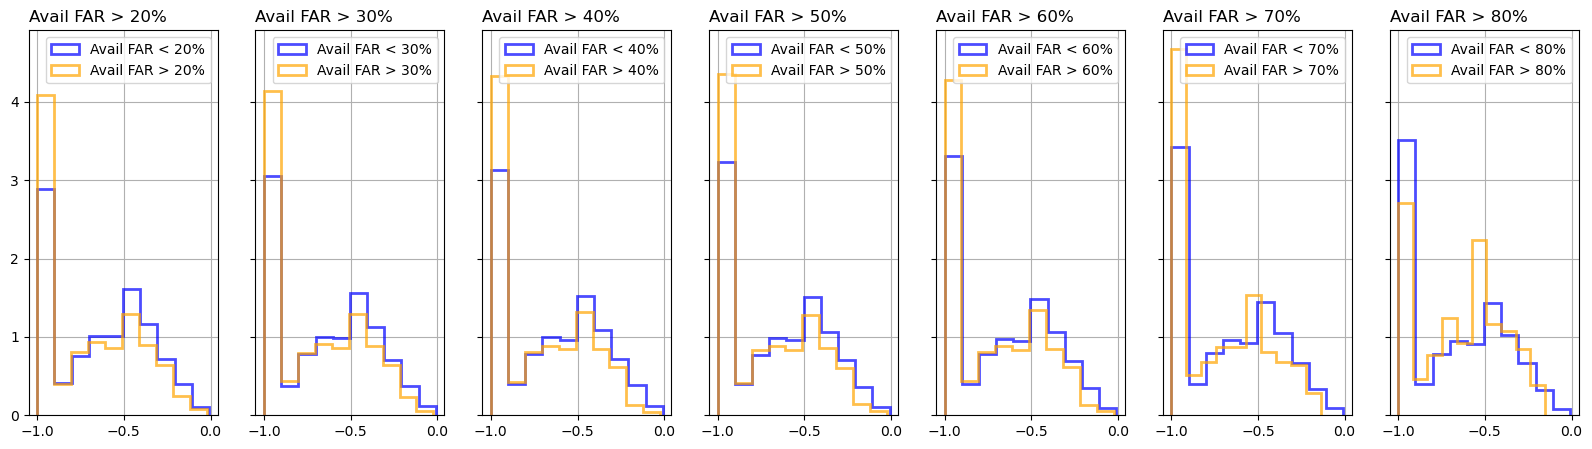

In [ ]:
fig,axs = plt.subplots( ncols=len(cats) , figsize=(20,5) , sharey=True )

for i,c in enumerate(cats):
    t = geo_dfj.copy()
    t[ f'availfar_perc_morethan_{c*100:.0f}'] = np.where( t['availfar_perc_07'] > c, True, False )
    t = t[ (t['change_uc'] > t['change_uc'].quantile(0.1)) & (t['change_uc'] < t['change_uc'].quantile(0.99)) ]
    t['change_uc_perc'] = t['change_uc'] / t['2007uc']

    ax = axs[i]
    
    t1 = t[ t[f'availfar_perc_morethan_{c*100:.0f}']==False]
    t2 = t[ t[f'availfar_perc_morethan_{c*100:.0f}']==True]

    t1['change_uc_perc'].hist(ax=ax, color='blue', density=True, alpha=0.7, histtype='step', lw=2)
    t2['change_uc_perc'].hist(ax=ax, color='orange', density=True, alpha=0.7, histtype='step', lw=2 )

    ax.set_title( f"Avail FAR > {c*100:.0f}%" , loc='left' )
    ax.legend( [f'Avail FAR < {c*100:.0f}%',f'Avail FAR > {c*100:.0f}%'] )

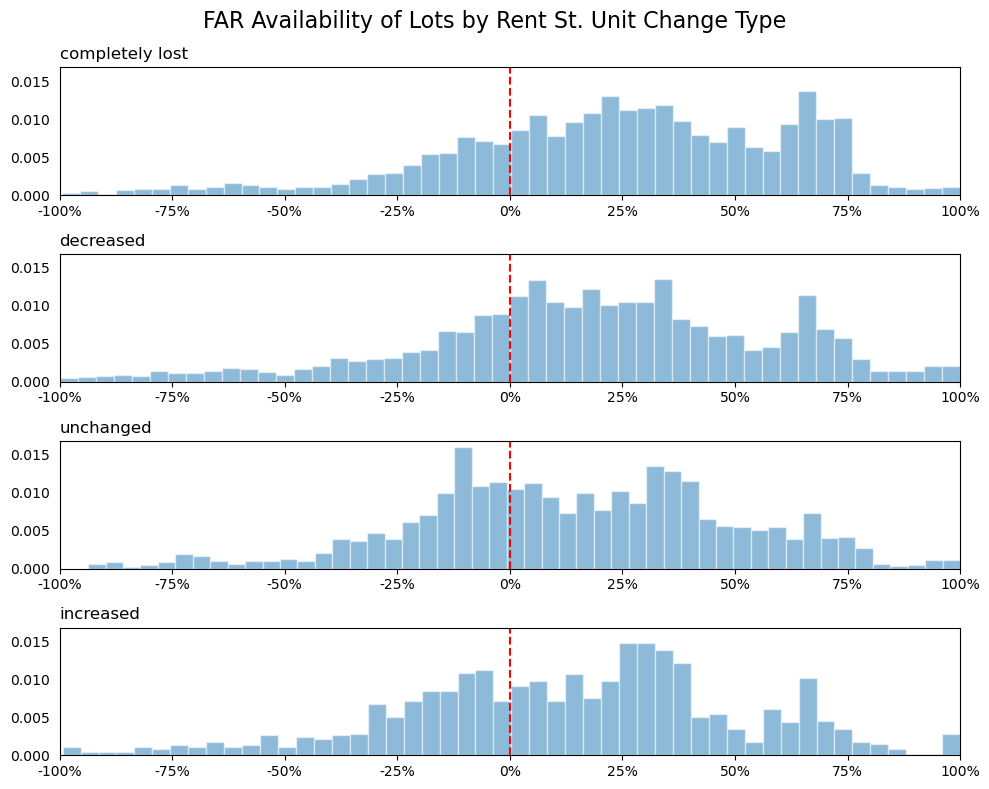

In [205]:
t = geo_dfj.copy()
t['change_uc_perc'] = (t['change_uc'] / t['2007uc'])

t['change_uc_cat'] = None
t.loc[t['change_uc_perc'] == 0, 'change_uc_cat'] = 'unchanged'
t.loc[t['change_uc_perc'] > 0, 'change_uc_cat'] = 'increased'
t.loc[t['change_uc_perc'] < 0, 'change_uc_cat'] = 'decreased'
t.loc[t['change_uc_perc'] == -1, 'change_uc_cat'] = 'completely lost'

t = t[ t['change_uc_perc'].notnull() ]

fig,axs = plt.subplots( figsize=(10,8), nrows = len(t['change_uc_cat'].unique()) , sharex = True, sharey=True)
for i,cat in enumerate( ['completely lost','decreased','unchanged','increased'] ):
    ax = axs[i]
    t1 = t[ t['change_uc_cat'] == cat ].copy()
    # t1 = t1[ t1['availfar_perc_07'].between( t1['availfar_perc_07'].quantile(0.01) , t1['availfar_perc_07'].quantile(0.99)) ]
    t1 = t1[ t1['availfar_perc_07'].between(-1,1 )  ]
    
    ax.hist( t1['availfar_perc_07'].mul(100) , bins=50, alpha=0.5, density=True, histtype='bar', ec='w', label=cat )
    ax.set_title( cat , loc='left')
    ax.tick_params(axis='x', labelbottom=True )
    ax.tick_params(axis='y', left=False )
    ax.axvline( 0, color='red', linestyle='--' )
    ax.set_xlim( -100, 100 )

    # xticklabels are in % format
    xticks = ax.get_xticks()
    ax.set_xticks( xticks , labels = [f'{int(i)}%' for i in xticks] )

fig.suptitle( "FAR Availability of Lots by Rent St. Unit Change Type", fontsize=16)
fig.tight_layout()

Change UC'de 4 durum olabilir:
- rent st units artti
- rent st unit = 0
- rent st unit <> -1,-0.01
- rent st == -1

1. Bunu bir anlasilir yap
2. 4 category'yi Map etmeye calis. 
3. Juan -1'le ilgileniyor cunku tum binanin donusmesi durumu => Bunlarin ortak ozellikleri nedir? vs -0.5  
4. 80%'de fark var. peki esas fark nerede baslayacak.  

Bunlari Google Slides haline getirelim.

## Basic Summaries

In [50]:
# Manhattan Core vs Non Manhattan core
# In Historic District vs not
# Rezoned vs not
# Available FAR vs not
# 'geo_region'

cols = ['historic_dist','geo_region','is_builtout_07','ZD_Change']

summary = pd.DataFrame()

for col in cols:
    gr = geo_dfj[geo_dfj['change_uc'] < 0].groupby( col ).agg({
        'change_uc':'count',
        '2007uc': 'sum',
        '2022uc': 'sum'
        })
    gr['Percent Change'] = ((gr['2022uc'] - gr['2007uc']) / gr['2007uc']).round(3)

    gr.columns = ['Number of Lots with Decrease', 'Rent St Unit Count 07', 'Rent St Unit Count 22','Rent St. Units Percent Change']

    gr['indicator'] = gr.index.name
    gr = gr.reset_index()

    gr = gr.set_index( ['indicator',col] )

    summary = pd.concat( [summary,gr] )

summary

Number of Lots with Decrease  Rent St Unit Count 07  \
indicator                                                                      
historic_dist  False                             7613                 164478   
               True                              2746                  33457   
geo_region     core mn                           8505                 143758   
               upper mn                          1854                  54177   
is_builtout_07 False                             4573                  64161   
               True                              5762                 133587   
ZD_Change      n                                 8685                 170135   
               y                                 1674                  27800   

                         Rent St Unit Count 22  Rent St. Units Percent Change  
indicator                                                                      
historic_dist  False                     66643                         -0.595  
               True                      13121                         -0.608  
geo_region     core mn                   53806                         -0.626  
               upper mn                  25958                         -0.521  
is_builtout_07 False                     23680                         -0.631  
               True                      56021                         -0.581  
ZD_Change      n                         68622                         -0.597  
               y                         11142                         -0.599

In [51]:
summary.to_excel( r"C:\Git_Repo\RentStabilization\DATA\RentStUnitChange_Summary.xlsx")

## Compare Branches.

In [15]:
geo_dfj['change_uc_updown'] = np.where(geo_dfj['change_uc'] > 0, 'up', np.where(geo_dfj['change_uc'] < 0, 'down', 'unchanged'))
geo_dfj['builtoutness'] = '07: ' + geo_dfj['is_builtout_07'].astype(str) + ' <> 22: ' + geo_dfj['is_builtout_22'].astype(str)
geo_dfj['recently_build'] = np.where(geo_dfj['yearbuilt_22'] >= 2007, True, False)
geo_dfj.head(3)

,BBL_07,BBL_24,2007uc,2022uc,cd,ZD_Change,address_07,unitsres_07,resarea_07,bldgarea_07,builtfar_07,maxallwfar_07,landmark_07,availfar_07,availfar_perc_07,is_builtout_07,address_22,yearbuilt_22,unitsres_22,resarea_22,bldgarea_22,builtfar_22,residfar_22,maxallwfar_22,availfar_22,availfar_perc_22,is_builtout_22,change_maxfar,change_uc,change_units,change_resarea,change_bldgarea,change_availfar,change_availfar_perc,change_uc_cat,change_maxfar_cat,change_availfar_cat,change_availfar_perc_cat,change_combined,xcoord,ycoord,geometry,index_right,historic_dist,change_uc_updown,builtoutness,recently_build
0,1009720001,1009720001,6179,8770,106,n,240 1 AVENUE,8756.0,8367942.0,8942176.0,3.34,3.44,False,0.10,0.029070,True,240 1 AVENUE,1945.0,8764.0,8367942.0,8942176.0,3.34,3.44,3.44,0.10,0.029070,True,0.0,2591,8.0,0.0,0.0,0.00,0.000000,increase,unchanged,unchanged,unchanged,Rent st: increase <> Avail FAR %: unchanged,990376.0,205864.0,POINT (990376.000 205864.000),NaN,False,up,07: True <> 22: True,False
1,1009780001,1009780001,1749,2480,106,n,342 1 AVENUE,2491.0,3102556.0,3122165.0,3.77,3.44,False,-0.33,-0.095930,True,342 1 AVENUE,1947.0,2491.0,3102556.0,3122165.0,3.77,3.44,3.44,-0.33,-0.095930,True,0.0,731,0.0,0.0,0.0,0.00,0.000000,increase,unchanged,unchanged,unchanged,Rent st: increase <> Avail FAR %: unchanged,990629.0,207012.0,POINT (990629.000 207012.000),NaN,False,up,07: True <> 22: True,False
2,1010890003,1010897502,0,1212,104,n,533 11 AVENUE,1266.0,854683.0,854683.0,21.97,12.00,False,-9.97,-0.830833,True,533 11 AVENUE,2005.0,1276.0,895990.0,954682.0,19.16,10.00,12.00,-7.16,-0.596667,True,0.0,1212,10.0,41307.0,99999.0,-2.81,0.234167,increase,unchanged,decrease,increase,Rent st: increase <> Avail FAR %: increase,984462.0,216453.0,POINT (984462.000 216453.000),NaN,False,up,07: True <> 22: True,False


Text(0.0, 1.0, 'Builtoutness Comparison')

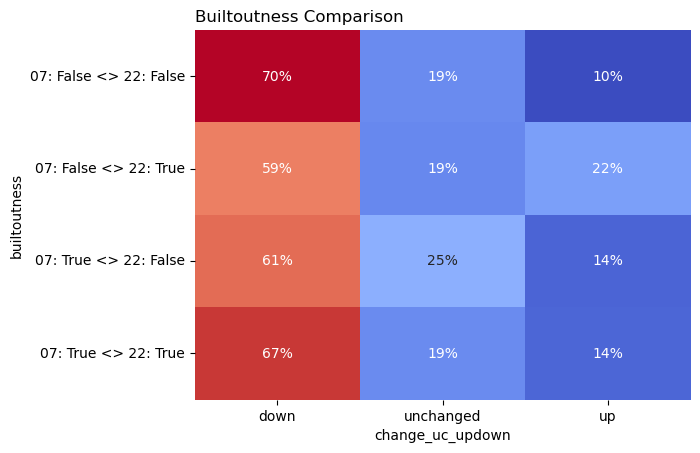

In [16]:
t = geo_dfj.dropna( subset=['is_builtout_07','is_builtout_22'] ).copy()
t = t.pivot_table( index='builtoutness', columns='change_uc_updown', values='BBL_07', aggfunc='count' )

sns.heatmap(
    t.div( t.sum(axis=1), axis=0 ),
    annot=True,
    fmt=".0%",
    cmap='coolwarm',
    cbar=False
)
plt.title( "Builtoutness Comparison" , loc='left')

Far Available (>80%):
- Built Recently > 2007
    - Rent St: Up vs Down

In [17]:
geo_dfj['geo_region'] = np.where( geo_dfj['cd'].isin(['110','109','112','208']) , 'upper mn', 'core mn')
geo_dfj['geo_region'].unique()

array(['core mn', 'upper mn'], dtype=object)

In [18]:
t = geo_dfj.copy()

pt = t.pivot_table( 
    index=['geo_region','historic_dist','ZD_Change','is_builtout_07','recently_build' ],
    columns='change_uc_updown', 
    values='cd', aggfunc='count', fill_value=0 
    ) 

pt['total'] = pt.sum(axis=1)

pt['down_perc'] = (pt['down'] / pt['total']).mul(100).round(0).astype(int)
pt['unchanged_perc'] = (pt['unchanged'] / pt['total']).mul(100).round(0).astype(int)
pt['up_perc'] = (pt['up'] / pt['total']).mul(100).round(0).astype(int)

pt

change_uc_updown                                                  down  \
geo_region historic_dist ZD_Change is_builtout_07 recently_build         
core mn    False         n         False          False           2667   
                                                  True              57   
                                   True           False           2176   
                                                  True               1   
                         y         False          False            280   
                                                  True               5   
                                   True           False            737   
                                                  True               2   
           True          n         False          False           1015   
                                                  True               1   
                                   True           False           1335   
                                                  True               1   
                         y         False          False             48   
                                   True           False            158   
                                                  True               1   
upper mn   False         n         False          False            362   
                                                  True               0   
                                   True           False            942   
                                                  True               0   
                         y         False          False             49   
                                                  True               1   
                                   True           False            318   
                                                  True               1   
           True          n         False          False             65   
                                                  True               1   
                                   True           False             38   
                         y         False          False             22   
                                   True           False             52   

change_uc_updown                                                  unchanged  \
geo_region historic_dist ZD_Change is_builtout_07 recently_build              
core mn    False         n         False          False                 587   
                                                  True                   32   
                                   True           False                 417   
                                                  True                    1   
                         y         False          False                 123   
                                                  True                    7   
                                   True           False                 201   
                                                  True                    4   
           True          n         False          False                 230   
                                                  True                    1   
                                   True           False                 206   
                                                  True                    0   
                         y         False          False                  14   
                                   True           False                  54   
                                                  True                    0   
upper mn   False         n         False          False                 198   
                                                  True                   12   
                                   True           False                 600   
                                                  True                    2   
                         y         False          False                  35   
                                         

In [19]:
pt2 = pt.join(
    t.groupby(['geo_region','historic_dist','ZD_Change','is_builtout_07','recently_build' ]).agg({'change_uc':'sum','2007uc':'sum','2022uc':'sum'}).rename(columns={'change_uc':'total_unit_change'})
)

pt2['Rent St Change Perc'] = (pt2['total_unit_change'] / pt2['2007uc']).mul(100).round(1)

pt2.columns = [
    'decrease', 'unchanged', 'increase', 
    'total', 
    'decrease (%)', 'unchanged (%)', 'increase (%)', 
    'Total Rent St. Unit Change',
    'Total Rent St Count 2007',
    'Total Rent St Count 2022',
    'Rent St Change Perc'
    ]

for i in ['decrease (%)', 'unchanged (%)', 'increase (%)']: pt2[i] = pt2[i].astype(str) + '%'

pt2.index = pt2.index.set_names(['region','in Historic Dist?','rezoning?','Available FAR <20%','Built after 2007?'])

pt2['Rent St Change Perc'] = pt2['Rent St Change Perc'].astype(str) + '%'

pt2

decrease  \
region   in Historic Dist? rezoning? Available FAR <20% Built after 2007?             
core mn  False             n         False              False                  2667   
                                                        True                     57   
                                     True               False                  2176   
                                                        True                      1   
                           y         False              False                   280   
                                                        True                      5   
                                     True               False                   737   
                                                        True                      2   
         True              n         False              False                  1015   
                                                        True                      1   
                                     True               False                  1335   
                                                        True                      1   
                           y         False              False                    48   
                                     True               False                   158   
                                                        True                      1   
upper mn False             n         False              False                   362   
                                                        True                      0   
                                     True               False                   942   
                                                        True                      0   
                           y         False              False                    49   
                                                        True                      1   
                                     True               False                   318   
                                                        True                      1   
         True              n         False              False                    65   
                                                        True                      1   
                                     True               False                    38   
                           y         False              False                    22   
                                     True               False                    52   

                                                                           unchanged  \
region   in Historic Dist? rezoning? Available FAR <20% Built after 2007?              
core mn  False             n         False              False                    587   
                                                        True                      32   
                                     True               False                    417   
                                                        True                       1   
                           y         False              False                    123   
                                                        True                       7   
                                     True               False                    201   
                                                        True                       4   
         True              n         False              False                    230   
                                                        True                       1   
                                     True               False                    206   
                                                        True                       0   
                           y         False              False                     14   
                                     True               False                     54   
                                                        

In [21]:
pt3 = pt.join(
    t[t['change_uc'] < 0].groupby(['geo_region','historic_dist','ZD_Change','is_builtout_07','recently_build' ]).agg({'change_uc':'sum','2007uc':'sum','2022uc':'sum'}).rename(columns={'change_uc':'total_unit_change'})
)

pt3['Rent St Change Perc'] = (pt3['total_unit_change'] / pt3['2007uc']).mul(100).round(1)

pt3.columns = [
    'decrease', 'unchanged', 'increase', 
    'total', 
    'decrease (%)', 'unchanged (%)', 'increase (%)', 
    'Total Rent St. Unit Change',
    'Total Rent St Count 2007',
    'Total Rent St Count 2022',
    'Rent St Change Perc'
    ]

for i in ['decrease (%)', 'unchanged (%)', 'increase (%)']: pt3[i] = pt3[i].astype(str) + '%'

pt3.index = pt3.index.set_names(['region','in Historic Dist?','rezoning?','Available FAR <20%','Built after 2007?'])

pt3['Rent St Change Perc'] = pt3['Rent St Change Perc'].astype(str) + '%'

pt3

decrease  \
region   in Historic Dist? rezoning? Available FAR <20% Built after 2007?             
core mn  False             n         False              False                  2667   
                                                        True                     57   
                                     True               False                  2176   
                                                        True                      1   
                           y         False              False                   280   
                                                        True                      5   
                                     True               False                   737   
                                                        True                      2   
         True              n         False              False                  1015   
                                                        True                      1   
                                     True               False                  1335   
                                                        True                      1   
                           y         False              False                    48   
                                     True               False                   158   
                                                        True                      1   
upper mn False             n         False              False                   362   
                                                        True                      0   
                                     True               False                   942   
                                                        True                      0   
                           y         False              False                    49   
                                                        True                      1   
                                     True               False                   318   
                                                        True                      1   
         True              n         False              False                    65   
                                                        True                      1   
                                     True               False                    38   
                           y         False              False                    22   
                                     True               False                    52   

                                                                           unchanged  \
region   in Historic Dist? rezoning? Available FAR <20% Built after 2007?              
core mn  False             n         False              False                    587   
                                                        True                      32   
                                     True               False                    417   
                                                        True                       1   
                           y         False              False                    123   
                                                        True                       7   
                                     True               False                    201   
                                                        True                       4   
         True              n         False              False                    230   
                                                        True                       1   
                                     True               False                    206   
                                                        True                       0   
                           y         False              False                     14   
                                     True               False                     54   
                                                        

In [22]:
pt3.to_excel( r"C:\Git_Repo\RentStabilization\DATA\rent_stabilization_change_Deliniated_Counts_OnlyDecrease.xlsx" )

In [25]:
pt2.to_excel( r"C:\Git_Repo\RentStabilization\DATA\rent_stabilization_change_Deliniated_Counts2.xlsx" )

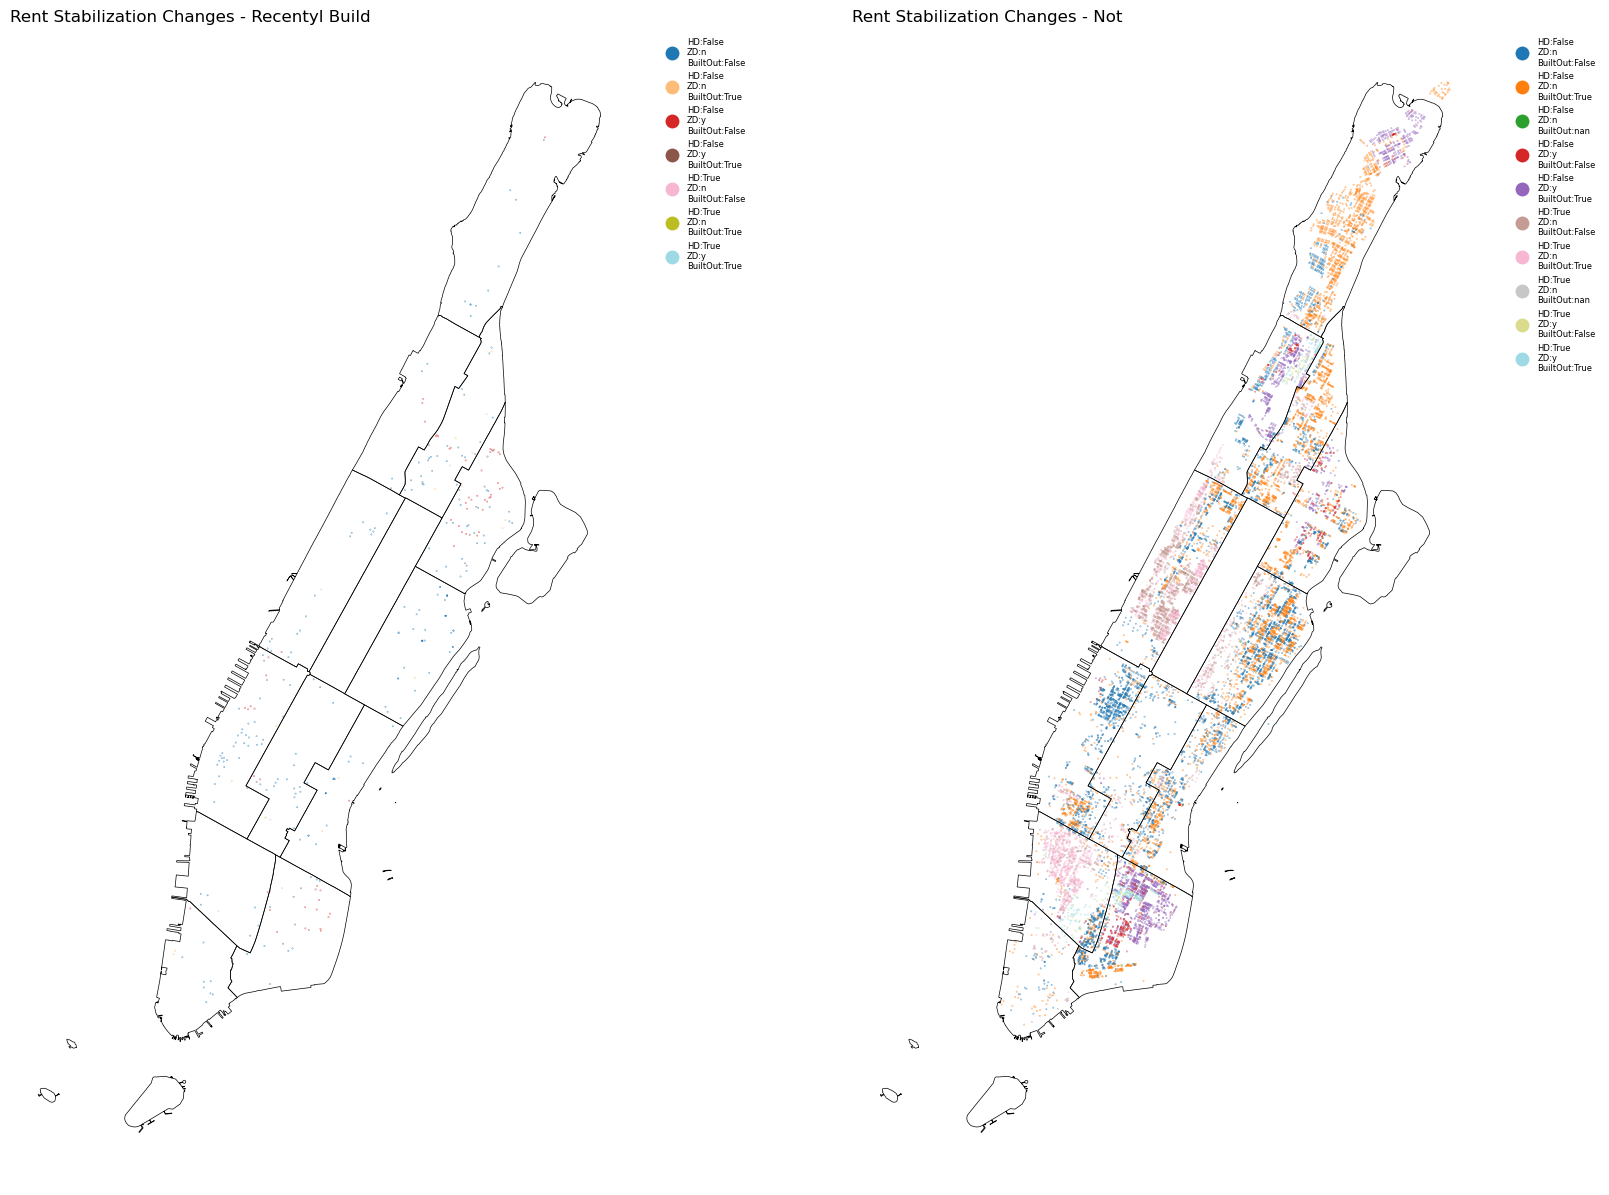

In [95]:
t = geo_dfj.copy()

geo_cd = gpd.read_file( r"D:\DATA\Community Districts.geojson" )
geo_cd = geo_cd[ geo_cd['boro_cd'].str.startswith('1') ].copy()
geo_cd = geo_cd.to_crs(2263)

t['rent_class'] = 'HD:' + t['historic_dist'].astype(str) + '\nZD:' + t['ZD_Change'].astype(str) + '\nBuiltOut:'+  t['is_builtout_07'].astype(str) 

fig,axs = plt.subplots( figsize=(20,15), ncols=2 )
ax = axs[0]
t[t['recently_build'] == True].plot(column='rent_class', cmap='tab20', legend=True, markersize=0.05, ax=ax, legend_kwds={'loc':'upper right', 'bbox_to_anchor': (1.2, 1), 'frameon':False, 'fontsize': 6})
geo_cd.plot( ax=ax, color='none', edgecolor='black', linewidth=0.5 )

ax.set_title( "Rent Stabilization Changes - Recentyl Build" , loc='left')
ax.axis('off')

ax = axs[1]
t[t['recently_build'] == False].plot(column='rent_class', cmap='tab20', legend=True, markersize=0.05, ax=ax, legend_kwds={'loc':'upper right', 'bbox_to_anchor': (1.2, 1), 'frameon':False, 'fontsize': 6})
geo_cd.plot( ax=ax, color='none', edgecolor='black', linewidth=0.5 )

ax.set_title( "Rent Stabilization Changes - Not" , loc='left')
ax.axis('off');

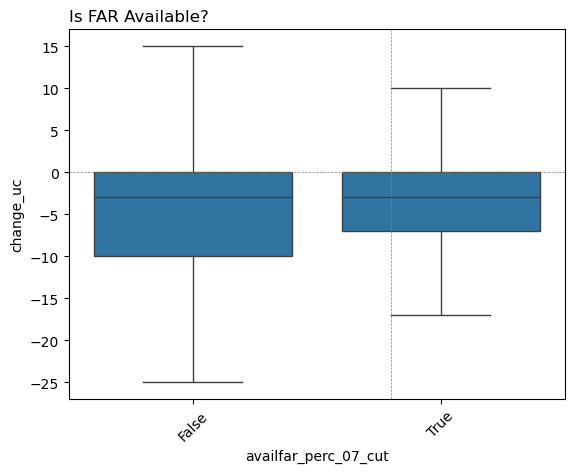

In [147]:
t = geo_dfj.copy()

# t = t[ (t['change_uc'] < 0) & (t['change_uc'] > -300) & (t['availfar_perc_07']>-10)].copy()
# t = t[ (t['change_uc'] < 0) & (t['change_uc'].notnull()) & (t['availfar_perc_07'].notnull())].copy()

# t['availfar_perc_07_qcut'] = pd.qcut( t['availfar_perc_07'], 8 )

t['availfar_perc_07_cut'] = t['availfar_perc_07'] > 0

sns.boxplot( x='availfar_perc_07_cut', y='change_uc', data=t, showfliers=False )

plt.title( 'Is FAR Available?' , loc='left')
plt.xticks(rotation=45)
plt.axhline( y=0, color='grey', linestyle='--' , lw=0.5)
plt.axvline( x=0.8, color='grey', linestyle='--', lw=0.5)


<Axes: xlabel='change_uc', ylabel='Count'>

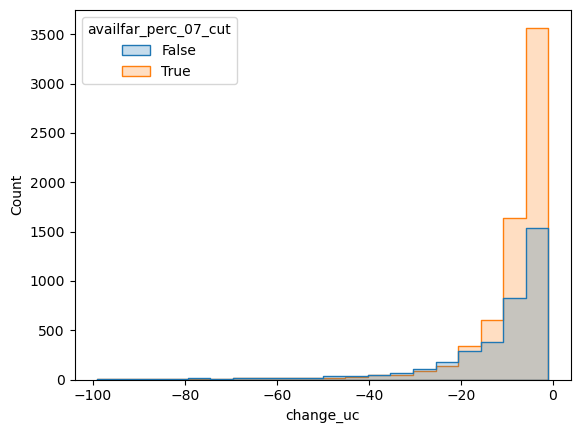

In [145]:
sns.histplot( t[t['change_uc']>-100], x='change_uc', hue='availfar_perc_07_cut', bins=20, element='step' )

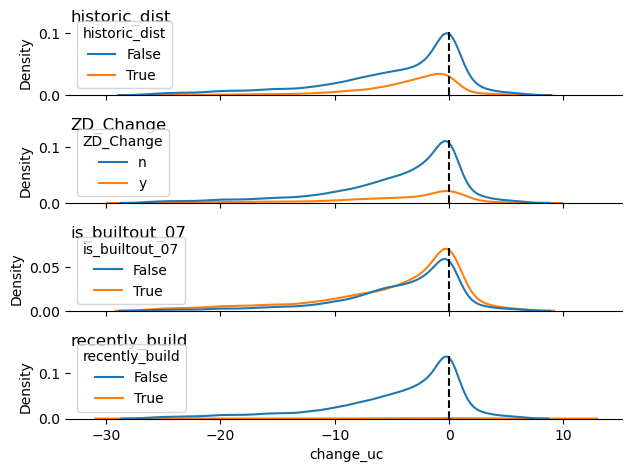

In [268]:
cols = ['historic_dist', 'ZD_Change', 'is_builtout_07', 'recently_build']

t = geo_dfj.copy()
t = t[ t['change_uc'].between(
    t['change_uc'].quantile(0.05),
    t['change_uc'].quantile(0.95)
    ) 
]


fig, axs = plt.subplots( nrows = len(cols), sharex=True )

for i,col in enumerate( cols ):
    ax = axs[i]

    sns.kdeplot( data=t, x='change_uc', hue=col, ax=ax )
    ax.set_title( col ,loc='left')
    ax.axvline( 0 , color='black', linestyle='--' )
    sns.despine( ax=ax, left=True )

fig.tight_layout( pad=1.0 )

## PLOTS

<Axes: xlabel='recent_built', ylabel='change_uc'>

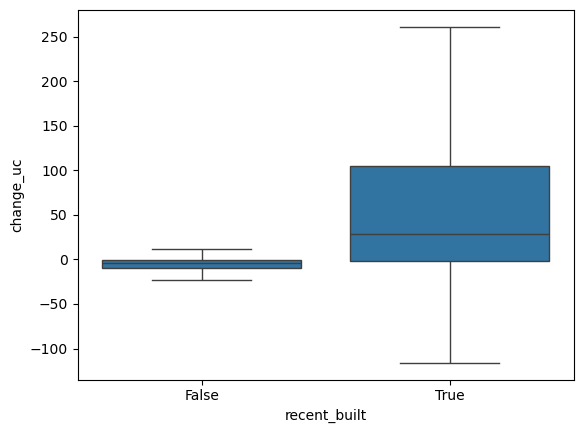

In [269]:
t = dfj[ dfj['change_uc'] != 0 ].copy()
t['recent_built'] = t['yearbuilt_22'] >= 2007

sns.boxplot(
    data = t,
    x = 'recent_built',
    y = 'change_uc',
    showfliers=False
)

In [270]:
geo_dfj.head(3)

,BBL_07,BBL_24,2007uc,2022uc,cd,ZD_Change,address_07,unitsres_07,resarea_07,bldgarea_07,builtfar_07,maxallwfar_07,landmark_07,availfar_07,availfar_perc_07,is_builtout_07,address_22,yearbuilt_22,unitsres_22,resarea_22,bldgarea_22,builtfar_22,residfar_22,maxallwfar_22,availfar_22,availfar_perc_22,is_builtout_22,change_maxfar,change_uc,change_units,change_resarea,change_bldgarea,change_availfar,change_availfar_perc,change_uc_cat,change_maxfar_cat,change_availfar_cat,change_availfar_perc_cat,change_combined,xcoord,ycoord,geometry,index_right,historic_dist,change_uc_updown,builtoutness,recently_build
0,1009720001,1009720001,6179,8770,106,n,240 1 AVENUE,8756.0,8367942.0,8942176.0,3.34,3.44,False,0.10,0.029070,True,240 1 AVENUE,1945.0,8764.0,8367942.0,8942176.0,3.34,3.44,3.44,0.10,0.029070,True,0.0,2591,8.0,0.0,0.0,0.00,0.000000,increase,unchanged,unchanged,unchanged,Rent st: increase <> Avail FAR %: unchanged,990376.0,205864.0,POINT (990376.000 205864.000),NaN,False,up,07: True <> 22: True,False
1,1009780001,1009780001,1749,2480,106,n,342 1 AVENUE,2491.0,3102556.0,3122165.0,3.77,3.44,False,-0.33,-0.095930,True,342 1 AVENUE,1947.0,2491.0,3102556.0,3122165.0,3.77,3.44,3.44,-0.33,-0.095930,True,0.0,731,0.0,0.0,0.0,0.00,0.000000,increase,unchanged,unchanged,unchanged,Rent st: increase <> Avail FAR %: unchanged,990629.0,207012.0,POINT (990629.000 207012.000),NaN,False,up,07: True <> 22: True,False
2,1010890003,1010897502,0,1212,104,n,533 11 AVENUE,1266.0,854683.0,854683.0,21.97,12.00,False,-9.97,-0.830833,True,533 11 AVENUE,2005.0,1276.0,895990.0,954682.0,19.16,10.00,12.00,-7.16,-0.596667,True,0.0,1212,10.0,41307.0,99999.0,-2.81,0.234167,increase,unchanged,decrease,increase,Rent st: increase <> Avail FAR %: increase,984462.0,216453.0,POINT (984462.000 216453.000),NaN,False,up,07: True <> 22: True,False


ValueError: cannot reindex on an axis with duplicate labels

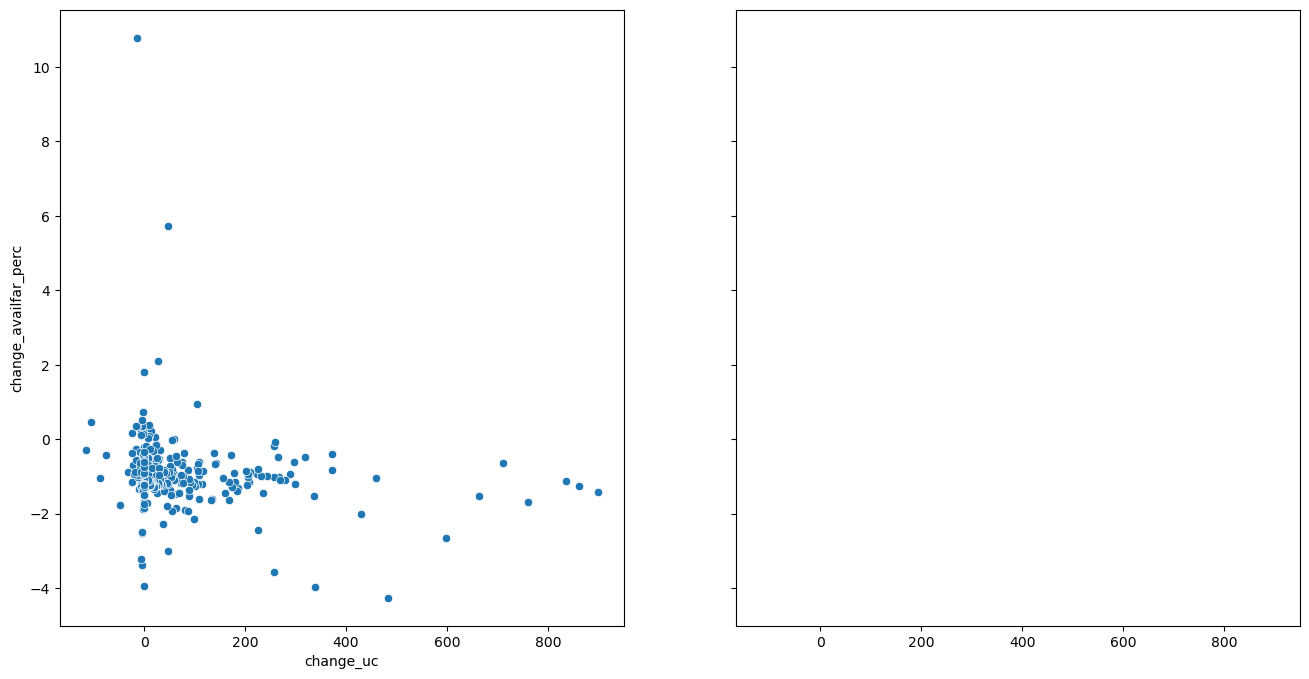

In [271]:
fig,axs = plt.subplots( ncols = 2 , figsize=(16,8) , sharex=True , sharey=True )
ax = axs[0]

geo_dfj['yearbuilt_22'] = geo_dfj['yearbuilt_22'].astype(float)
t = geo_dfj.copy()
t = t[t['change_availfar_perc'] < 100 ].copy()

sns.scatterplot(
    data = t[ t['yearbuilt_22'] >=2007 ],
    ax=ax,
    x = 'change_uc',
    y = 'change_availfar_perc',
)

ax = axs[1]
sns.scatterplot(
    data = t[ t['yearbuilt_22'] < 2007 ],
    ax=ax,
    x = 'change_uc',
    y = 'change_availfar_perc',
)


Compare change Rent St with FAR (available and Max)

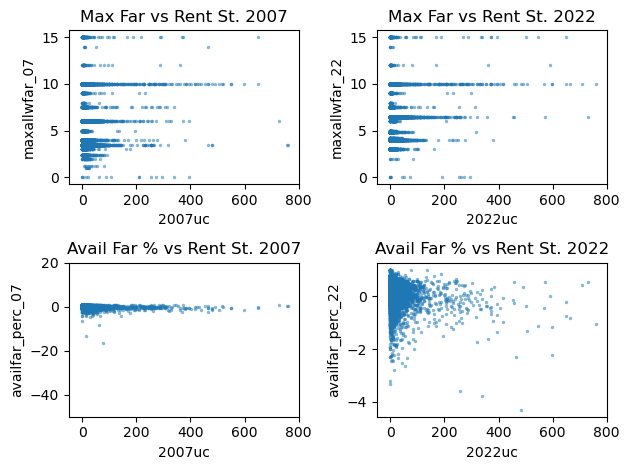

In [ ]:
fig,axs = plt.subplots( ncols = 2, nrows = 2 )
axs = axs.flatten()

ax = axs[0]
sns.scatterplot( x='2007uc', y='maxallwfar_07', data=dfj, ax=ax , s=5, ec=None, alpha=0.5)
ax.set_title('Max Far vs Rent St. 2007') 
ax.set_xlim( -50, 800 )

ax = axs[1]
sns.scatterplot( x='2022uc', y='maxallwfar_22', data=dfj, ax=ax, s=5, ec=None, alpha=0.5 )
ax.set_title('Max Far vs Rent St. 2022') 
ax.set_xlim( -50, 800 )

ax = axs[2]
sns.scatterplot( x='2007uc', y='availfar_perc_07', data=dfj, ax=ax, s=5, ec=None, alpha=0.5 )
ax.set_title('Avail Far % vs Rent St. 2007') 
ax.set_xlim( -50, 800 )
ax.set_ylim( -50, 20 )

ax = axs[3]
sns.scatterplot( x='2022uc', y='availfar_perc_22', data=dfj, ax=ax, s=5, ec=None, alpha=0.5 )
ax.set_title('Avail Far % vs Rent St. 2022')
ax.set_xlim( -50, 800 )


fig.tight_layout()

Text(0.5, 1.0, 'Change in Avail Far % vs Change in Rent St.')

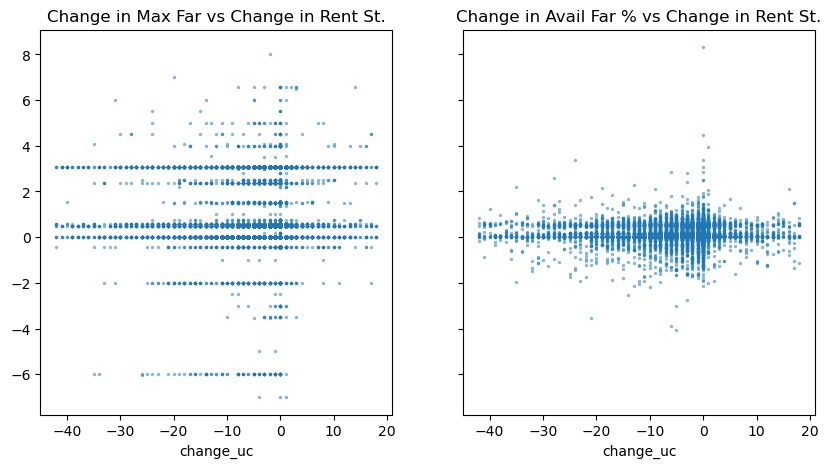

In [ ]:

fig,axs = plt.subplots( ncols = 2, sharey=True, sharex=True, figsize=(10,5) )

ax = axs[0]
sns.scatterplot( 
    data=dfj[ 
        (dfj['change_uc'] < dfj['change_uc'].quantile(0.975)) & 
        (dfj['change_uc'] > dfj['change_uc'].quantile(0.025)) & 
        (dfj['change_uc'] < 1000 )
        ], # filter out the outliers
    ax=ax,
    x='change_uc', 
    y='change_maxfar', 
    s=5, ec=None, alpha=0.5 )

ax.set_title('Change in Max Far vs Change in Rent St.')
ax.set_ylabel('')

ax = axs[1]
sns.scatterplot( 
    data=dfj[ 
        (dfj['change_uc'] < dfj['change_uc'].quantile(0.975)) &
        (dfj['change_uc'] > dfj['change_uc'].quantile(0.025)) &
        (dfj['change_availfar']>-40) 
    ], # filter out the outliers
    ax=ax,
    x='change_uc', 
    y='change_availfar_perc', 
    s=5, ec=None, alpha=0.5 )

ax.set_ylabel('Change in Avail Far')
ax.set_title('Change in Avail Far % vs Change in Rent St.')


Simplify data to `increase, no change and decrease` since the data is lot scale, maybe that is enough.

Compare max and avail far vales for rent st increase or decrease.  
I am seeing very slight change here. We can calculate a `p-value` here to test stat significance but not sure

Text(0.5, 1.0, 'Change in Rent St. vs Change in Avail Far %')

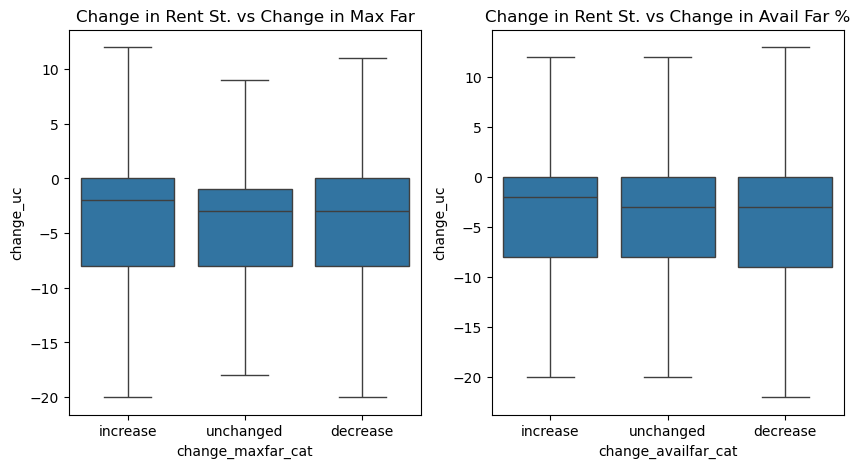

In [ ]:
fig,axs = plt.subplots( figsize=(10,5) , ncols=2 )

ax= axs[0]
col = 'change_maxfar'
sns.boxplot(
    data=dfj[(dfj[col] > dfj[col].quantile(0.01)) & (dfj[col]<dfj[col].quantile(0.99))], ax=ax,
    x='change_maxfar_cat',
    y='change_uc',
    showfliers=False,
    # xorder is increase, unchanged, decrease
    order=['increase','unchanged','decrease']

)
ax.set_title('Change in Rent St. vs Change in Max Far')

ax = axs[1]
col = 'change_availfar_perc'
sns.boxplot(
    data=dfj[(dfj[col] > dfj[col].quantile(0.01)) & (dfj[col]<dfj[col].quantile(0.99)) ], ax=ax,
    x='change_availfar_cat',
    y='change_uc',
    showfliers=False,
    order=['increase','unchanged','decrease']
)
ax.set_title('Change in Rent St. vs Change in Avail Far %')


## in CD

In [ ]:
cd = dfj[ 
        (dfj['change_uc'] < dfj['change_uc'].quantile(0.99)) &
        (dfj['change_uc'] > dfj['change_uc'].quantile(0.01) ) &
        (dfj['change_availfar']>-100) &
        (dfj['change_availfar_perc'].between(-10,10) ) & 
        (dfj['yearbuilt_22'] > 2007 )
    ].groupby('cd', as_index=False).agg({
    'maxallwfar_07': 'sum',
    'maxallwfar_22': 'sum',
    'availfar_07': 'sum',
    'availfar_22': 'sum',
    '2007uc': 'sum',
    '2022uc': 'sum',
    'change_maxfar': 'sum',
    'change_uc': 'sum',
    'change_availfar': 'sum',
    'change_availfar_perc': 'sum'
})

cd

,cd,maxallwfar_07,maxallwfar_22,availfar_07,availfar_22,2007uc,2022uc,change_maxfar,change_uc,change_availfar,change_availfar_perc
0,101,42.04,43.00,28.42,-5.60,0.0,129.0,0.96,129.0,34.98,-4.108961
1,102,42.02,49.50,33.33,-14.21,13.0,29.0,7.48,16.0,55.02,-6.132536
2,103,73.28,85.00,35.96,-10.68,80.0,354.0,11.72,274.0,58.36,-11.607500
3,104,120.16,143.52,85.80,-46.01,359.0,537.0,23.36,178.0,155.17,-15.134267
4,105,125.00,135.00,72.17,-67.79,62.0,44.0,10.00,-18.0,149.96,-13.659000
5,106,146.04,147.00,105.46,-62.67,97.0,195.0,0.96,98.0,169.09,-17.797452
6,107,41.52,44.00,35.93,2.30,16.0,64.0,2.48,48.0,36.11,-4.385170
7,108,329.00,330.50,202.35,-93.01,230.0,22.0,1.50,-208.0,296.86,-30.358231
8,109,16.34,18.50,16.34,-3.31,92.0,118.0,2.16,26.0,21.81,-4.612115
9,110,110.50,158.50,67.42,23.41,50.0,439.0,48.00,389.0,92.01,-12.498644


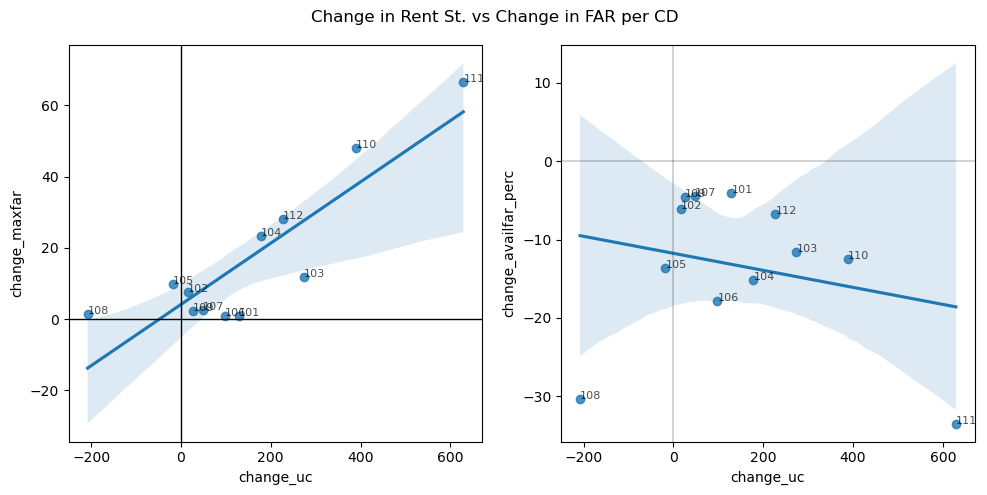

In [ ]:
fig,axs = plt.subplots( figsize=(10,5) , ncols=2 )
ax = axs[0]
sns.regplot(
    data=cd, ax=ax,
    x='change_uc',
    y='change_maxfar'
    )

ax.axhline(0, color='black', lw=1)
ax.axvline(0, color='black', lw=1)

ax = axs[1]
sns.regplot(
    data=cd, ax=ax,
    x='change_uc',
    y='change_availfar_perc'
    )

ax.axhline(0, color='black', lw=0.25)
ax.axvline(0, color='black', lw=0.25)

for i, row in cd.iterrows():
    axs[0].text(row['change_uc'], row['change_maxfar'], str(row['cd']), fontsize=8, alpha=0.7)
    axs[1].text(row['change_uc'], row['change_availfar_perc'], str(row['cd']), fontsize=8, alpha=0.7)

fig.suptitle( "Change in Rent St. vs Change in FAR per CD" )
fig.tight_layout()

## Mapping

In [ ]:
geo_dfj = gpd.GeoDataFrame( dfj, geometry=gpd.points_from_xy( dfj['xcoord'], dfj['ycoord'] ) , crs=2263 )
geo_dfj['recent_built'] = geo_dfj['yearbuilt_22'] >= 2007
geo_dfj.head(3)

,BBL_07,BBL_24,2007uc,2022uc,cd,address_07,unitsres_07,resarea_07,bldgarea_07,builtfar_07,maxallwfar_07,availfar_07,availfar_perc_07,address_22,yearbuilt_22,unitsres_22,resarea_22,bldgarea_22,builtfar_22,maxallwfar_22,availfar_22,availfar_perc_22,change_maxfar,change_uc,change_units,change_resarea,change_bldgarea,change_availfar,change_availfar_perc,change_uc_cat,change_maxfar_cat,change_availfar_cat,change_availfar_perc_cat,change_combined,xcoord,ycoord,geometry,recent_built
0,1009720001,1009720001,6179.0,8770.0,106,240 1 AVENUE,8756.0,8367942.0,8942176.0,3.34,3.44,0.10,0.02907,240 1 AVENUE,1945.0,8764.0,8367942.0,8942176.0,3.34,6.5,3.16,0.486154,3.06,2591.0,8.0,0.0,0.0,0.00,0.457084,increase,increase,unchanged,increase,Rent st: increase <> Avail FAR %: increase,0990379,0205835,POINT (990379.000 205835.000),False
1,1009780001,1009780001,1749.0,2480.0,106,342 1 AVENUE,2491.0,3102556.0,3122165.0,3.77,3.44,-0.33,-0.09593,342 1 AVENUE,1947.0,2491.0,3102556.0,3122165.0,3.77,6.5,2.73,0.420000,3.06,731.0,0.0,0.0,0.0,0.00,0.515930,increase,increase,unchanged,increase,Rent st: increase <> Avail FAR %: increase,0990626,0206995,POINT (990626.000 206995.000),False
2,1010890003,1010897502,0.0,1212.0,104,533 11 AVENUE,1266.0,854683.0,854683.0,21.97,10.00,-11.97,-1.19700,533 11 AVENUE,2005.0,1276.0,895990.0,954682.0,19.16,10.0,-9.16,-0.916000,0.00,1212.0,10.0,41307.0,99999.0,-2.81,0.281000,increase,unchanged,decrease,increase,Rent st: increase <> Avail FAR %: increase,0984487,0216424,POINT (984487.000 216424.000),False


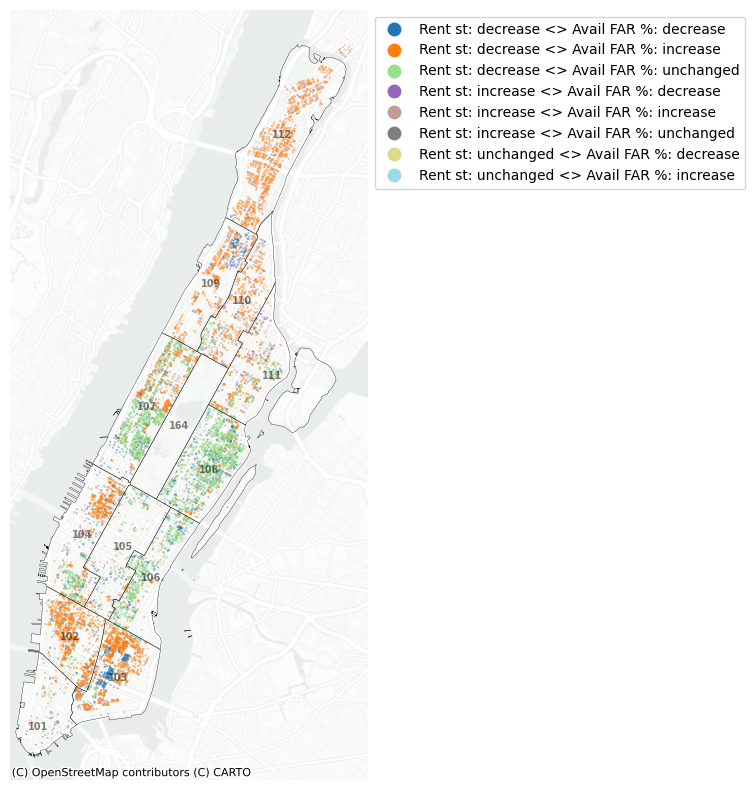

In [ ]:
import contextily as ctx

geo_cd = gpd.read_file( r"D:\DATA\Community Districts.geojson" )
geo_cd = geo_cd[ geo_cd['boro_cd'].str.startswith('1') ].copy()
geo_cd = geo_cd.to_crs(3857)

fig,ax = plt.subplots( figsize=(10,10) )

t = geo_dfj[ ~((geo_dfj['change_uc_cat'] == 'unchanged') & (geo_dfj['change_availfar_cat'] == 'unchanged')) ]
t = t[ t['change_availfar_perc'].between(-100,100) ].copy()
t = t.to_crs(3857)

t.plot( ax=ax, column='change_combined', marker='o', markersize=0.05,
       cmap='tab20', legend=True, legend_kwds={'loc': 'upper left', 'bbox_to_anchor': (1, 1)} )

ctx.add_basemap( ax=ax, source=ctx.providers.CartoDB.PositronNoLabels , alpha=0.5 )

geo_cd.plot( ax=ax, edgecolor='black', facecolor='none', lw=0.25 )
# label the community districts
for i, row in geo_cd.iterrows():
    plt.text( row['geometry'].centroid.x, row['geometry'].centroid.y, row['boro_cd'], fontsize=7, alpha=0.5, fontweight='bold', ha='center', va='center' )

ax.axis('off');


Text(0.5, 1.0, 'Rent St. Change vs FAR Change\nfor not Built after 2007')

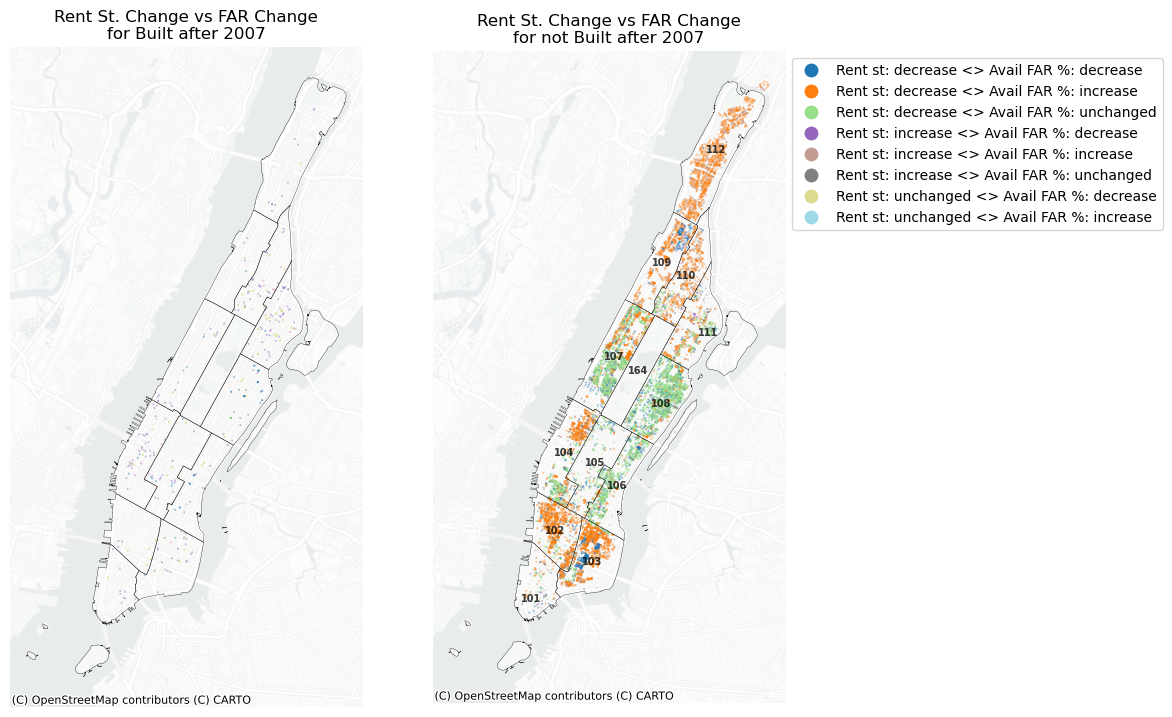

In [ ]:
import contextily as ctx

geo_cd = gpd.read_file( r"D:\DATA\Community Districts.geojson" )
geo_cd = geo_cd[ geo_cd['boro_cd'].str.startswith('1') ].copy()
geo_cd = geo_cd.to_crs(3857)

bounds = geo_cd.total_bounds


fig,axs = plt.subplots( figsize=(10,10) , ncols = 2)

ax = axs[0]
t = geo_dfj[ ~((geo_dfj['change_uc_cat'] == 'unchanged') & (geo_dfj['change_availfar_cat'] == 'unchanged')) ]
t = t[ t['change_availfar_perc'].between(-100,100) ]
t = t[ t['recent_built'] == True ].copy()
t = t.to_crs(3857)

t.plot( ax=ax, column='change_combined', marker='o', markersize=0.05,
       cmap='tab20', legend=False)
geo_cd.plot( ax=ax, edgecolor='black', facecolor='none', lw=0.25 )
# label the community districts
for i, row in geo_cd.iterrows():
    plt.text( row['geometry'].centroid.x, row['geometry'].centroid.y, row['boro_cd'], fontsize=7, alpha=0.5, fontweight='bold', ha='center', va='center' )

ax.axis('off')

ctx.add_basemap( ax=ax, source=ctx.providers.CartoDB.PositronNoLabels , alpha=0.5 )
ax.set_title('Rent St. Change vs FAR Change\nfor Built after 2007')    


ax = axs[1]
t = geo_dfj[ ~((geo_dfj['change_uc_cat'] == 'unchanged') & (geo_dfj['change_availfar_cat'] == 'unchanged')) ]
t = t[ t['change_availfar_perc'].between(-100,100) ]
t = t[ t['recent_built'] == False ].copy()

t = t.to_crs(3857)

t.plot( ax=ax, column='change_combined', marker='o', markersize=0.05,
       cmap='tab20', legend=True, legend_kwds={'loc': 'upper left', 'bbox_to_anchor': (1, 1)} )
geo_cd.plot( ax=ax, edgecolor='black', facecolor='none', lw=0.25 )

# label the community districts

for i, row in geo_cd.iterrows():
    plt.text( row['geometry'].centroid.x, row['geometry'].centroid.y, row['boro_cd'], fontsize=7, alpha=0.5, fontweight='bold', ha='center', va='center' )

ax.axis('off')

ctx.add_basemap( ax=ax, source=ctx.providers.CartoDB.PositronNoLabels , alpha=0.5 )

ax.set_title('Rent St. Change vs FAR Change\nfor not Built after 2007')    



In [ ]:
cd_table = geo_dfj.pivot_table(
    index='cd',
    columns='change_combined',
    aggfunc='count',
    values='BBL_07',
)

cd_table_percentage = cd_table.div(cd_table.sum(axis=1), axis=0)
cd_table_percentage

change_combined,Rent st: decrease <> FAR: decrease,Rent st: decrease <> FAR: increase,Rent st: decrease <> FAR: unchanged,Rent st: increase <> FAR: decrease,Rent st: increase <> FAR: increase,Rent st: increase <> FAR: unchanged,Rent st: unchanged <> FAR: decrease,Rent st: unchanged <> FAR: increase,Rent st: unchanged <> FAR: unchanged
cd,,,,,,,,,
101,0.013333,0.213333,0.273333,NaN,0.073333,0.140000,0.006667,0.173333,0.106667
102,0.008178,0.688476,0.046840,0.001487,0.097398,0.005948,0.001487,0.133829,0.016357
103,0.109920,0.526005,0.044504,0.009651,0.110456,0.015550,0.026273,0.134584,0.023056
104,0.011438,0.426471,0.274510,0.003268,0.084150,0.046569,0.001634,0.102941,0.049020
105,0.020253,0.149367,0.544304,0.002532,0.022785,0.093671,0.002532,0.030380,0.134177
106,0.025490,0.061765,0.735294,0.003922,0.010784,0.054902,0.001961,0.008824,0.097059
107,0.007433,0.194141,0.558373,0.000437,0.023174,0.059904,0.003498,0.043725,0.109314
108,0.035375,0.029336,0.767472,0.001294,0.005177,0.059534,0.006903,0.003451,0.091458
109,0.111111,0.442177,NaN,0.038549,0.148526,0.002268,0.070295,0.187075,NaN


Text(95.7222222222222, 0.5, '')

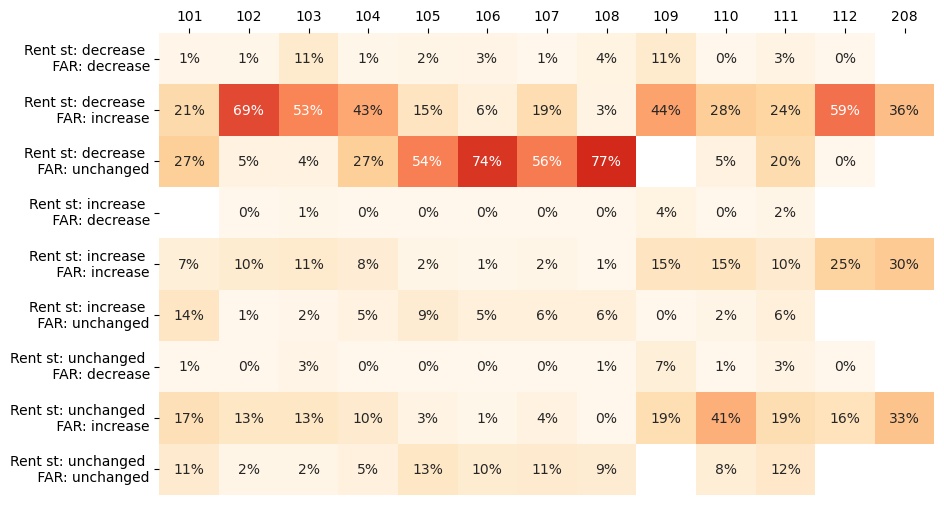

In [ ]:
fig,ax = plt.subplots( figsize=(10,6) )
sns.heatmap(
    ax=ax,
    data = cd_table_percentage.T,
    cmap='OrRd',
    annot=True,
    fmt=".0%",
    vmin=0, vmax=1,
    cbar=False
)

# put x-axis labels on top
ax.xaxis.tick_top()

ylabels = ax.get_yticklabels()
ylabels = [i.get_text().replace("<>","\n") for i in ylabels]
ax.set_yticklabels( ylabels )

ax.set_xlabel('')
ax.set_ylabel('')

## Rezonings

In [ ]:
dataUrl = 'https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/nyzma/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson'
rezone = gpd.read_file( dataUrl )
rezone = rezone.set_crs(4326)
rezone = rezone.to_crs(2263)
rezone - rezone[ rezone['STATUS'] == 'Adopted' ].copy()
rezone['datetime'] = pd.to_datetime(rezone['EFFECTIVE'], unit='ms')
rezone = rezone[ rezone['datetime'].dt.year >= 2007 ].copy()
print( rezone.shape[0] )
rezone.head(3)


C:\Users\cansu\AppData\Local\Temp\ipykernel_17816\2233248583.py:5: FutureWarning: '-' operator will be deprecated. Use the 'difference' method instead.
  rezone - rezone[ rezone['STATUS'] == 'Adopted' ].copy()


540


,OBJECTID,EFFECTIVE,STATUS,ULURPNO,LUCATS,PROJECT_NAME,Shape__Area,Shape__Length,geometry,datetime
0,1,1.552435e+12,Adopted,060432zmq,060432,Douglaston Parkway Rezoning,157598.778640,1969.212699,"POLYGON ((1054403.275 218666.790, 1054438.937 ...",2019-03-13
1,2,1.255478e+12,Adopted,060551zmq,060551,BRIARWOOD PLAZA,29679.878052,735.793336,"POLYGON ((1047145.104 218925.009, 1047385.647 ...",2009-10-14
2,3,1.256688e+12,Adopted,060419zmq,060419,SOUTH CONDUIT REZONING,38034.872589,820.472092,"POLYGON ((1054113.461 181836.300, 1054297.621 ...",2009-10-28


In [ ]:
geo_dfj = gpd.GeoDataFrame( dfj, geometry=gpd.points_from_xy( dfj['xcoord'], dfj['ycoord'] ) , crs=2263 )

print( geo_dfj.shape[0] )

geo_dfj = gpd.sjoin( geo_dfj, rezone[['PROJECT_NAME','geometry']], predicate='within', how='left' )

geo_dfj['is_rezoned'] = geo_dfj['index_right'].notnull()

print( geo_dfj.shape[0] )

# geo_dfj.head(3)

15311
15424


<Axes: xlabel='is_rezoned', ylabel='change_uc'>

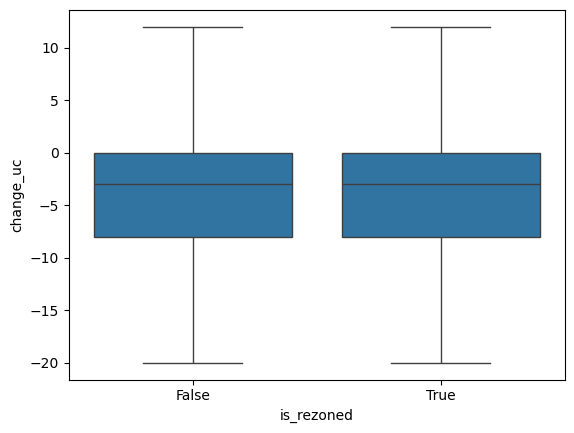

In [ ]:
sns.boxplot( data=geo_dfj, x='is_rezoned', y='change_uc', showfliers=False )

<Axes: xlabel='change_uc', ylabel='change_availfar'>

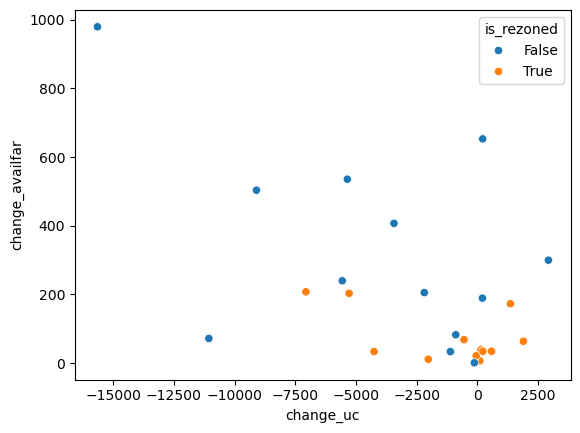

In [ ]:
gr = geo_dfj[
    geo_dfj['change_availfar'] > geo_dfj['change_availfar'].quantile(0.01)
].groupby(['cd','is_rezoned']).agg({
    "change_uc": "sum",
    "change_maxfar": "sum",
    "change_availfar": "sum"
})

sns.scatterplot(
    data=gr,
    x='change_uc',
    y='change_availfar',
    hue='is_rezoned'
)
